# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
#copula_pv = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_1616067/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_1616067/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_1616067/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.2, "tau_b": 0.7 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [8]:
output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/1000 [00:00<07:44,  2.15it/s]

[1/1000] train=25822.5410  val=25823.1328  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  0%|          | 3/1000 [00:00<04:56,  3.37it/s]

[2/1000] train=37.1563  val=38.3701  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00
[3/1000] train=39.3694  val=37.9022  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  0%|          | 5/1000 [00:01<03:38,  4.55it/s]

[4/1000] train=39.0697  val=37.4350  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00
[5/1000] train=35.2060  val=36.9688  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  1%|          | 7/1000 [00:01<03:11,  5.19it/s]

[6/1000] train=34.1901  val=36.5029  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00
[7/1000] train=35.9848  val=36.0357  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  1%|          | 9/1000 [00:02<02:58,  5.54it/s]

[8/1000] train=34.6338  val=35.5688  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00
[9/1000] train=36.8841  val=35.1020  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  1%|          | 10/1000 [00:02<02:55,  5.64it/s]

[10/1000] train=34.3138  val=34.6358  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  1%|          | 11/1000 [00:02<03:07,  5.27it/s]

[11/1000] train=36.4453  val=34.1696  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  1%|          | 12/1000 [00:02<03:16,  5.04it/s]

[12/1000] train=35.5318  val=33.7032  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0631   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  1%|▏         | 13/1000 [00:02<03:21,  4.89it/s]

[13/1000] train=35.7602  val=33.2364  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  1%|▏         | 14/1000 [00:03<03:25,  4.79it/s]

[14/1000] train=35.9692  val=32.7700  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 15/1000 [00:03<03:28,  4.72it/s]

[15/1000] train=33.1141  val=32.3041  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 16/1000 [00:03<03:32,  4.63it/s]

[16/1000] train=30.6585  val=31.8390  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 17/1000 [00:03<03:33,  4.61it/s]

[17/1000] train=31.9404  val=31.3747  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0695 σmin=0.0695 σmax=0.0695   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 18/1000 [00:03<03:33,  4.60it/s]

[18/1000] train=33.1708  val=30.9113  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 19/1000 [00:04<03:33,  4.59it/s]

[19/1000] train=30.0607  val=30.4485  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 20/1000 [00:04<03:33,  4.58it/s]

[20/1000] train=30.5154  val=29.9865  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 21/1000 [00:04<04:02,  4.04it/s]

[21/1000] train=29.0903  val=29.5248  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 22/1000 [00:05<04:23,  3.72it/s]

[22/1000] train=29.7235  val=29.0631  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 23/1000 [00:05<04:37,  3.52it/s]

[23/1000] train=27.7778  val=28.6021  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0781 σmax=0.0781   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▏         | 24/1000 [00:05<04:49,  3.37it/s]

[24/1000] train=28.6172  val=28.1414  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  2%|▎         | 25/1000 [00:05<04:56,  3.29it/s]

[25/1000] train=27.7960  val=27.6816  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0811   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 26/1000 [00:06<05:00,  3.24it/s]

[26/1000] train=27.1939  val=27.2225  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 27/1000 [00:06<05:03,  3.21it/s]

[27/1000] train=27.3076  val=26.7640  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 28/1000 [00:06<05:04,  3.19it/s]

[28/1000] train=26.8852  val=26.3060  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 29/1000 [00:07<05:05,  3.18it/s]

[29/1000] train=25.1882  val=25.8484  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0875 σmin=0.0875 σmax=0.0876   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 30/1000 [00:07<05:06,  3.17it/s]

[30/1000] train=27.3797  val=25.3915  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0892   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 31/1000 [00:08<06:03,  2.67it/s]

[31/1000] train=25.7094  val=24.9348  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0909 σmin=0.0909 σmax=0.0910   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 32/1000 [00:08<06:47,  2.38it/s]

[32/1000] train=25.6400  val=24.4782  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0927   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 33/1000 [00:09<07:16,  2.21it/s]

[33/1000] train=24.3686  val=24.0221  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  3%|▎         | 34/1000 [00:09<07:35,  2.12it/s]

[34/1000] train=23.7986  val=23.5665  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▎         | 35/1000 [00:10<07:49,  2.06it/s]

[35/1000] train=23.5181  val=23.1115  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0981   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▎         | 36/1000 [00:10<07:59,  2.01it/s]

[36/1000] train=23.2155  val=22.6574  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1000   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▎         | 37/1000 [00:11<08:10,  1.96it/s]

[37/1000] train=22.2365  val=22.2040  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1019   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▍         | 38/1000 [00:11<08:14,  1.94it/s]

[38/1000] train=20.7074  val=21.7515  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1038 σmin=0.1038 σmax=0.1038   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▍         | 39/1000 [00:12<08:17,  1.93it/s]

[39/1000] train=21.5306  val=21.2998  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1058   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▍         | 40/1000 [00:12<08:18,  1.93it/s]

[40/1000] train=21.3552  val=20.8491  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1078   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▍         | 41/1000 [00:13<10:11,  1.57it/s]

[41/1000] train=21.2324  val=20.3988  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1099   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▍         | 42/1000 [00:14<11:37,  1.37it/s]

[42/1000] train=21.3670  val=19.9491  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1119 σmin=0.1119 σmax=0.1120   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▍         | 43/1000 [00:15<12:37,  1.26it/s]

[43/1000] train=20.0294  val=19.5003  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1141   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▍         | 44/1000 [00:16<13:17,  1.20it/s]

[44/1000] train=18.7380  val=19.0525  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1162   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  4%|▍         | 45/1000 [00:17<13:45,  1.16it/s]

[45/1000] train=19.0467  val=18.6057  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1183 σmax=0.1184   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▍         | 46/1000 [00:18<14:14,  1.12it/s]

[46/1000] train=19.1291  val=18.1600  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1206 σmin=0.1206 σmax=0.1206   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▍         | 47/1000 [00:19<14:27,  1.10it/s]

[47/1000] train=17.9135  val=17.7156  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1228 σmax=0.1229   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▍         | 48/1000 [00:20<14:34,  1.09it/s]

[48/1000] train=18.1116  val=17.2718  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1251 σmax=0.1252   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▍         | 49/1000 [00:21<14:38,  1.08it/s]

[49/1000] train=17.0816  val=16.8291  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1275 σmin=0.1275 σmax=0.1276   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▌         | 50/1000 [00:22<14:41,  1.08it/s]

[50/1000] train=16.9308  val=16.3868  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1299 σmin=0.1298 σmax=0.1300   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▌         | 51/1000 [00:23<14:44,  1.07it/s]

[51/1000] train=16.8686  val=15.9447  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1323 σmin=0.1323 σmax=0.1324   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▌         | 52/1000 [00:24<14:44,  1.07it/s]

[52/1000] train=15.5640  val=15.5029  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1348 σmin=0.1347 σmax=0.1348   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▌         | 53/1000 [00:25<14:46,  1.07it/s]

[53/1000] train=15.5128  val=15.0618  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1373 σmin=0.1372 σmax=0.1374   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  5%|▌         | 54/1000 [00:25<14:45,  1.07it/s]

[54/1000] train=14.4815  val=14.6217  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1399 σmin=0.1398 σmax=0.1399   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▌         | 55/1000 [00:26<14:46,  1.07it/s]

[55/1000] train=15.4026  val=14.1822  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1424 σmin=0.1423 σmax=0.1425   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▌         | 56/1000 [00:27<14:52,  1.06it/s]

[56/1000] train=13.7855  val=13.7447  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1451 σmin=0.1450 σmax=0.1451   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▌         | 57/1000 [00:28<14:50,  1.06it/s]

[57/1000] train=13.2227  val=13.3081  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1477 σmin=0.1476 σmax=0.1478   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▌         | 58/1000 [00:29<14:47,  1.06it/s]

[58/1000] train=13.6161  val=12.8722  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1505 σmin=0.1503 σmax=0.1505   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▌         | 59/1000 [00:30<14:44,  1.06it/s]

[59/1000] train=12.8665  val=12.4364  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1532 σmin=0.1531 σmax=0.1533   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▌         | 60/1000 [00:31<14:42,  1.06it/s]

[60/1000] train=12.3055  val=11.9998  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1560 σmin=0.1559 σmax=0.1561   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▌         | 61/1000 [00:32<14:40,  1.07it/s]

[61/1000] train=11.6886  val=11.5639  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1589 σmin=0.1587 σmax=0.1590   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▌         | 62/1000 [00:33<14:39,  1.07it/s]

[62/1000] train=11.4168  val=11.1288  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1618 σmin=0.1616 σmax=0.1619   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▋         | 63/1000 [00:34<14:38,  1.07it/s]

[63/1000] train=10.6952  val=10.6949  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1647 σmin=0.1645 σmax=0.1648   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▋         | 64/1000 [00:35<14:37,  1.07it/s]

[64/1000] train=10.7354  val=10.2627  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1677 σmin=0.1675 σmax=0.1678   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  6%|▋         | 65/1000 [00:36<14:36,  1.07it/s]

[65/1000] train=10.6568  val=9.8326  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1708 σmin=0.1705 σmax=0.1709   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 66/1000 [00:37<14:35,  1.07it/s]

[66/1000] train=9.8460  val=9.4050  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1738 σmin=0.1736 σmax=0.1740   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 67/1000 [00:38<14:34,  1.07it/s]

[67/1000] train=9.7744  val=8.9792  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1770 σmin=0.1767 σmax=0.1771   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 68/1000 [00:39<14:41,  1.06it/s]

[68/1000] train=9.5246  val=8.5552  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1802 σmin=0.1799 σmax=0.1803   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 69/1000 [00:40<14:39,  1.06it/s]

[69/1000] train=7.7781  val=8.1331  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1834 σmin=0.1831 σmax=0.1835   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 70/1000 [00:41<14:35,  1.06it/s]

[70/1000] train=8.6529  val=7.7116  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1867 σmin=0.1863 σmax=0.1868   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 71/1000 [00:41<14:32,  1.06it/s]

[71/1000] train=7.3504  val=7.2910  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1900 σmin=0.1897 σmax=0.1902   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 72/1000 [00:42<14:30,  1.07it/s]

[72/1000] train=7.5145  val=6.8710  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1934 σmin=0.1930 σmax=0.1936   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 73/1000 [00:43<14:29,  1.07it/s]

[73/1000] train=6.5334  val=6.4512  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1968 σmin=0.1964 σmax=0.1970   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  7%|▋         | 74/1000 [00:44<14:28,  1.07it/s]

[74/1000] train=6.4707  val=6.0324  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2003 σmin=0.1999 σmax=0.2005   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 75/1000 [00:45<14:27,  1.07it/s]

[75/1000] train=5.5926  val=5.6135  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2038 σmin=0.2034 σmax=0.2041   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 76/1000 [00:46<14:27,  1.07it/s]

[76/1000] train=5.3094  val=5.1959  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2074 σmin=0.2070 σmax=0.2077   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 77/1000 [00:47<14:25,  1.07it/s]

[77/1000] train=5.6491  val=4.7794  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2111 σmin=0.2106 σmax=0.2113   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 78/1000 [00:48<14:24,  1.07it/s]

[78/1000] train=5.2608  val=4.3641  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2148 σmin=0.2142 σmax=0.2150   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 79/1000 [00:49<14:23,  1.07it/s]

[79/1000] train=4.3324  val=3.9497  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2185 σmin=0.2180 σmax=0.2188   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 80/1000 [00:50<14:22,  1.07it/s]

[80/1000] train=4.3256  val=3.5369  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2223 σmin=0.2217 σmax=0.2226   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 81/1000 [00:51<14:21,  1.07it/s]

[81/1000] train=3.0099  val=3.1241  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2262 σmin=0.2255 σmax=0.2265   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 82/1000 [00:52<14:19,  1.07it/s]

[82/1000] train=3.1834  val=2.7138  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2301 σmin=0.2294 σmax=0.2305   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 83/1000 [00:53<14:17,  1.07it/s]

[83/1000] train=2.7999  val=2.3051  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2341 σmin=0.2334 σmax=0.2344   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 84/1000 [00:54<14:24,  1.06it/s]

[84/1000] train=2.0012  val=1.8988  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2381 σmin=0.2373 σmax=0.2385   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  8%|▊         | 85/1000 [00:55<14:24,  1.06it/s]

[85/1000] train=2.0076  val=1.4953  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2422 σmin=0.2414 σmax=0.2426   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▊         | 86/1000 [00:56<14:22,  1.06it/s]

[86/1000] train=1.6314  val=1.0930  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2463 σmin=0.2455 σmax=0.2468   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▊         | 87/1000 [00:57<15:19,  1.01s/it]

[87/1000] train=0.7255  val=0.6929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2505 σmin=0.2496 σmax=0.2510   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▉         | 88/1000 [00:58<14:59,  1.01it/s]

[88/1000] train=0.6377  val=0.2932  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2547 σmin=0.2538 σmax=0.2553   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▉         | 89/1000 [00:59<14:44,  1.03it/s]

[89/1000] train=0.7807  val=-0.1051  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2590 σmin=0.2580 σmax=0.2596   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▉         | 90/1000 [01:00<14:34,  1.04it/s]

[90/1000] train=-0.2803  val=-0.5024  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2634 σmin=0.2623 σmax=0.2640   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▉         | 91/1000 [01:00<14:26,  1.05it/s]

[91/1000] train=-0.9136  val=-0.8984  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2678 σmin=0.2667 σmax=0.2685   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▉         | 92/1000 [01:01<14:21,  1.05it/s]

[92/1000] train=-0.3088  val=-1.2943  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2723 σmin=0.2711 σmax=0.2730   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▉         | 93/1000 [01:02<14:17,  1.06it/s]

[93/1000] train=-1.2762  val=-1.6897  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2768 σmin=0.2755 σmax=0.2776   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


  9%|▉         | 94/1000 [01:03<14:15,  1.06it/s]

[94/1000] train=-1.3975  val=-2.0834  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2814 σmin=0.2801 σmax=0.2822   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|▉         | 95/1000 [01:04<14:13,  1.06it/s]

[95/1000] train=-1.6982  val=-2.4742  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2861 σmin=0.2847 σmax=0.2869   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|▉         | 96/1000 [01:05<14:10,  1.06it/s]

[96/1000] train=-2.4607  val=-2.8632  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2908 σmin=0.2893 σmax=0.2917   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|▉         | 97/1000 [01:06<14:08,  1.06it/s]

[97/1000] train=-2.3808  val=-3.2523  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2956 σmin=0.2940 σmax=0.2965   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|▉         | 98/1000 [01:07<14:06,  1.07it/s]

[98/1000] train=-3.5819  val=-3.6380  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3004 σmin=0.2987 σmax=0.3014   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|▉         | 99/1000 [01:08<14:05,  1.07it/s]

[99/1000] train=-3.0499  val=-4.0209  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3053 σmin=0.3035 σmax=0.3063   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|█         | 100/1000 [01:09<14:04,  1.07it/s]

[100/1000] train=-3.8489  val=-4.4019  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3103 σmin=0.3084 σmax=0.3113   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|█         | 101/1000 [01:10<14:03,  1.07it/s]

[101/1000] train=-4.3894  val=-4.7808  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3153 σmin=0.3133 σmax=0.3164   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|█         | 102/1000 [01:11<14:01,  1.07it/s]

[102/1000] train=-4.8227  val=-5.1548  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3203 σmin=0.3183 σmax=0.3215   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|█         | 103/1000 [01:12<14:00,  1.07it/s]

[103/1000] train=-5.5203  val=-5.5275  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3255 σmin=0.3233 σmax=0.3267   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|█         | 104/1000 [01:13<14:00,  1.07it/s]

[104/1000] train=-5.9199  val=-5.8997  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3307 σmin=0.3284 σmax=0.3320   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 10%|█         | 105/1000 [01:14<14:06,  1.06it/s]

[105/1000] train=-5.5470  val=-6.2709  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3359 σmin=0.3335 σmax=0.3373   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█         | 106/1000 [01:15<14:05,  1.06it/s]

[106/1000] train=-6.4154  val=-6.6390  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3412 σmin=0.3387 σmax=0.3427   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█         | 107/1000 [01:15<14:02,  1.06it/s]

[107/1000] train=-6.7386  val=-7.0063  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3466 σmin=0.3439 σmax=0.3482   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█         | 108/1000 [01:16<13:59,  1.06it/s]

[108/1000] train=-6.8468  val=-7.3720  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3520 σmin=0.3492 σmax=0.3537   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█         | 109/1000 [01:17<13:57,  1.06it/s]

[109/1000] train=-7.2026  val=-7.7365  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3575 σmin=0.3545 σmax=0.3593   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█         | 110/1000 [01:18<13:54,  1.07it/s]

[110/1000] train=-7.4479  val=-8.1018  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3630 σmin=0.3599 σmax=0.3649   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█         | 111/1000 [01:19<13:53,  1.07it/s]

[111/1000] train=-8.7825  val=-8.4694  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3687 σmin=0.3653 σmax=0.3706   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█         | 112/1000 [01:20<13:51,  1.07it/s]

[112/1000] train=-7.8060  val=-8.8345  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3743 σmin=0.3708 σmax=0.3764   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█▏        | 113/1000 [01:21<13:49,  1.07it/s]

[113/1000] train=-8.9822  val=-9.1937  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3800 σmin=0.3763 σmax=0.3822   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 11%|█▏        | 114/1000 [01:22<13:48,  1.07it/s]

[114/1000] train=-8.9038  val=-9.5508  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3858 σmin=0.3819 σmax=0.3882   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 115/1000 [01:23<13:47,  1.07it/s]

[115/1000] train=-9.7924  val=-9.9061  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3917 σmin=0.3875 σmax=0.3941   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 116/1000 [01:24<13:47,  1.07it/s]

[116/1000] train=-10.0831  val=-10.2590  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3976 σmin=0.3932 σmax=0.4002   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 117/1000 [01:25<13:47,  1.07it/s]

[117/1000] train=-10.3869  val=-10.6109  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4036 σmin=0.3990 σmax=0.4063   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 118/1000 [01:26<13:45,  1.07it/s]

[118/1000] train=-10.1534  val=-10.9614  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4096 σmin=0.4048 σmax=0.4124   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 119/1000 [01:27<13:45,  1.07it/s]

[119/1000] train=-10.6822  val=-11.3084  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4157 σmin=0.4106 σmax=0.4186   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 120/1000 [01:28<13:44,  1.07it/s]

[120/1000] train=-11.0770  val=-11.6517  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4218 σmin=0.4165 σmax=0.4249   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 121/1000 [01:29<13:43,  1.07it/s]

[121/1000] train=-11.3600  val=-11.9906  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4280 σmin=0.4224 σmax=0.4313   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 122/1000 [01:30<13:43,  1.07it/s]

[122/1000] train=-12.1109  val=-12.3285  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4343 σmin=0.4284 σmax=0.4377   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 123/1000 [01:30<13:42,  1.07it/s]

[123/1000] train=-12.2108  val=-12.6659  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4406 σmin=0.4344 σmax=0.4442   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▏        | 124/1000 [01:31<13:40,  1.07it/s]

[124/1000] train=-13.0537  val=-13.0009  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4470 σmin=0.4405 σmax=0.4507   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 12%|█▎        | 125/1000 [01:32<13:39,  1.07it/s]

[125/1000] train=-13.0616  val=-13.3321  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4534 σmin=0.4467 σmax=0.4574   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 126/1000 [01:33<13:37,  1.07it/s]

[126/1000] train=-13.6131  val=-13.6617  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4599 σmin=0.4529 σmax=0.4640   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 127/1000 [01:34<13:36,  1.07it/s]

[127/1000] train=-14.2146  val=-13.9907  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4665 σmin=0.4592 σmax=0.4708   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 128/1000 [01:35<13:35,  1.07it/s]

[128/1000] train=-14.4973  val=-14.3144  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4731 σmin=0.4654 σmax=0.4776   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 129/1000 [01:36<13:35,  1.07it/s]

[129/1000] train=-14.1192  val=-14.6385  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4797 σmin=0.4717 σmax=0.4844   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 130/1000 [01:37<13:34,  1.07it/s]

[130/1000] train=-14.9246  val=-14.9654  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4865 σmin=0.4781 σmax=0.4914   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 131/1000 [01:38<13:33,  1.07it/s]

[131/1000] train=-15.5139  val=-15.2956  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4932 σmin=0.4845 σmax=0.4984   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 132/1000 [01:39<13:32,  1.07it/s]

[132/1000] train=-15.1120  val=-15.6205  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5000 σmin=0.4909 σmax=0.5054   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 133/1000 [01:40<13:40,  1.06it/s]

[133/1000] train=-15.8074  val=-15.9379  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5069 σmin=0.4973 σmax=0.5125   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 13%|█▎        | 134/1000 [01:41<13:38,  1.06it/s]

[134/1000] train=-15.8303  val=-16.2563  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5138 σmin=0.5038 σmax=0.5197   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▎        | 135/1000 [01:42<13:35,  1.06it/s]

[135/1000] train=-15.9220  val=-16.5736  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5208 σmin=0.5103 σmax=0.5270   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▎        | 136/1000 [01:43<13:32,  1.06it/s]

[136/1000] train=-16.4645  val=-16.8881  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5279 σmin=0.5170 σmax=0.5343   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▎        | 137/1000 [01:44<13:30,  1.06it/s]

[137/1000] train=-16.5177  val=-17.1991  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5350 σmin=0.5236 σmax=0.5416   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▍        | 138/1000 [01:45<13:29,  1.07it/s]

[138/1000] train=-17.2713  val=-17.5075  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5421 σmin=0.5303 σmax=0.5490   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▍        | 139/1000 [01:45<13:27,  1.07it/s]

[139/1000] train=-17.2561  val=-17.8121  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5493 σmin=0.5371 σmax=0.5565   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▍        | 140/1000 [01:46<13:25,  1.07it/s]

[140/1000] train=-18.5522  val=-18.1140  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5566 σmin=0.5439 σmax=0.5641   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▍        | 141/1000 [01:47<13:24,  1.07it/s]

[141/1000] train=-18.0220  val=-18.4170  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5639 σmin=0.5506 σmax=0.5717   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▍        | 142/1000 [01:48<13:23,  1.07it/s]

[142/1000] train=-18.1019  val=-18.7143  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5712 σmin=0.5575 σmax=0.5793   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▍        | 143/1000 [01:49<14:18,  1.00s/it]

[143/1000] train=-19.0929  val=-19.0017  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5786 σmin=0.5643 σmax=0.5871   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▍        | 144/1000 [01:50<14:01,  1.02it/s]

[144/1000] train=-19.3593  val=-19.2908  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5861 σmin=0.5712 σmax=0.5948   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 14%|█▍        | 145/1000 [01:51<13:48,  1.03it/s]

[145/1000] train=-19.7508  val=-19.5806  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5935 σmin=0.5781 σmax=0.6027   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▍        | 146/1000 [01:52<13:39,  1.04it/s]

[146/1000] train=-19.5932  val=-19.8726  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6011 σmin=0.5850 σmax=0.6106   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▍        | 147/1000 [01:53<13:32,  1.05it/s]

[147/1000] train=-19.8985  val=-20.1630  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6087 σmin=0.5920 σmax=0.6185   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▍        | 148/1000 [01:54<13:28,  1.05it/s]

[148/1000] train=-19.7890  val=-20.4519  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6163 σmin=0.5990 σmax=0.6265   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▍        | 149/1000 [01:55<13:25,  1.06it/s]

[149/1000] train=-20.4302  val=-20.7361  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6239 σmin=0.6060 σmax=0.6346   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▌        | 150/1000 [01:56<13:21,  1.06it/s]

[150/1000] train=-20.6014  val=-21.0157  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6316 σmin=0.6129 σmax=0.6427   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▌        | 151/1000 [01:57<13:18,  1.06it/s]

[151/1000] train=-20.4674  val=-21.2940  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6393 σmin=0.6199 σmax=0.6509   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▌        | 152/1000 [01:58<13:15,  1.07it/s]

[152/1000] train=-21.2664  val=-21.5636  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6471 σmin=0.6269 σmax=0.6591   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▌        | 153/1000 [01:59<13:14,  1.07it/s]

[153/1000] train=-21.4893  val=-21.8312  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6549 σmin=0.6338 σmax=0.6674   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 15%|█▌        | 154/1000 [02:00<13:12,  1.07it/s]

[154/1000] train=-22.3247  val=-22.0992  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6627 σmin=0.6409 σmax=0.6757   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▌        | 155/1000 [02:01<13:11,  1.07it/s]

[155/1000] train=-21.9900  val=-22.3682  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6706 σmin=0.6480 σmax=0.6841   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▌        | 156/1000 [02:02<13:10,  1.07it/s]

[156/1000] train=-22.1231  val=-22.6318  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6785 σmin=0.6552 σmax=0.6925   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▌        | 157/1000 [02:03<13:09,  1.07it/s]

[157/1000] train=-22.7778  val=-22.8946  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6865 σmin=0.6623 σmax=0.7010   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▌        | 158/1000 [02:03<13:08,  1.07it/s]

[158/1000] train=-22.8804  val=-23.1610  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6945 σmin=0.6695 σmax=0.7096   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▌        | 159/1000 [02:04<13:08,  1.07it/s]

[159/1000] train=-22.6290  val=-23.4293  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7025 σmin=0.6766 σmax=0.7182   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▌        | 160/1000 [02:05<13:06,  1.07it/s]

[160/1000] train=-23.0079  val=-23.7018  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7106 σmin=0.6837 σmax=0.7268   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▌        | 161/1000 [02:06<13:05,  1.07it/s]

[161/1000] train=-22.6779  val=-23.9691  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7187 σmin=0.6908 σmax=0.7355   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▌        | 162/1000 [02:07<13:03,  1.07it/s]

[162/1000] train=-23.5570  val=-24.2375  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7268 σmin=0.6980 σmax=0.7442   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▋        | 163/1000 [02:08<13:02,  1.07it/s]

[163/1000] train=-23.3527  val=-24.5045  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7350 σmin=0.7052 σmax=0.7530   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▋        | 164/1000 [02:09<13:01,  1.07it/s]

[164/1000] train=-24.7405  val=-24.7683  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7432 σmin=0.7124 σmax=0.7618   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 16%|█▋        | 165/1000 [02:10<13:10,  1.06it/s]

[165/1000] train=-23.6736  val=-25.0316  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7514 σmin=0.7195 σmax=0.7707   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 166/1000 [02:11<13:08,  1.06it/s]

[166/1000] train=-24.4715  val=-25.2943  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7597 σmin=0.7267 σmax=0.7796   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 167/1000 [02:12<13:06,  1.06it/s]

[167/1000] train=-25.1740  val=-25.5504  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7680 σmin=0.7337 σmax=0.7886   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 168/1000 [02:13<13:03,  1.06it/s]

[168/1000] train=-24.9208  val=-25.8036  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7763 σmin=0.7408 σmax=0.7976   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 169/1000 [02:14<13:01,  1.06it/s]

[169/1000] train=-25.5567  val=-26.0509  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7847 σmin=0.7479 σmax=0.8067   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 170/1000 [02:15<12:59,  1.07it/s]

[170/1000] train=-26.2299  val=-26.2929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7931 σmin=0.7548 σmax=0.8158   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 171/1000 [02:16<12:57,  1.07it/s]

[171/1000] train=-25.4517  val=-26.5308  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8014 σmin=0.7616 σmax=0.8249   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 172/1000 [02:17<12:56,  1.07it/s]

[172/1000] train=-25.9156  val=-26.7606  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8099 σmin=0.7684 σmax=0.8341   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 173/1000 [02:18<12:54,  1.07it/s]

[173/1000] train=-26.0729  val=-26.9886  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8183 σmin=0.7750 σmax=0.8433   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 17%|█▋        | 174/1000 [02:19<12:53,  1.07it/s]

[174/1000] train=-27.1220  val=-27.2130  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8268 σmin=0.7817 σmax=0.8526   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 175/1000 [02:19<12:52,  1.07it/s]

[175/1000] train=-26.5571  val=-27.4345  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8353 σmin=0.7885 σmax=0.8619   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 176/1000 [02:20<12:51,  1.07it/s]

[176/1000] train=-26.6049  val=-27.6521  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8438 σmin=0.7951 σmax=0.8712   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 177/1000 [02:21<12:50,  1.07it/s]

[177/1000] train=-27.9834  val=-27.8683  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8523 σmin=0.8019 σmax=0.8806   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 178/1000 [02:22<12:49,  1.07it/s]

[178/1000] train=-27.3230  val=-28.0801  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8608 σmin=0.8087 σmax=0.8900   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 179/1000 [02:23<12:48,  1.07it/s]

[179/1000] train=-27.1180  val=-28.2854  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8694 σmin=0.8155 σmax=0.8995   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 180/1000 [02:24<12:53,  1.06it/s]

[180/1000] train=-28.3217  val=-28.4953  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8780 σmin=0.8223 σmax=0.9090   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 181/1000 [02:25<12:51,  1.06it/s]

[181/1000] train=-27.8612  val=-28.7015  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8866 σmin=0.8291 σmax=0.9185   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 182/1000 [02:26<12:49,  1.06it/s]

[182/1000] train=-27.7323  val=-28.9049  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8952 σmin=0.8358 σmax=0.9281   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 183/1000 [02:27<12:48,  1.06it/s]

[183/1000] train=-28.8776  val=-29.1057  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9038 σmin=0.8426 σmax=0.9377   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 184/1000 [02:28<12:45,  1.07it/s]

[184/1000] train=-28.6467  val=-29.3043  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9124 σmin=0.8493 σmax=0.9473   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 18%|█▊        | 185/1000 [02:29<12:45,  1.06it/s]

[185/1000] train=-28.5111  val=-29.5036  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9211 σmin=0.8559 σmax=0.9570   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▊        | 186/1000 [02:30<12:46,  1.06it/s]

[186/1000] train=-29.5757  val=-29.7062  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9298 σmin=0.8627 σmax=0.9667   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▊        | 187/1000 [02:31<12:44,  1.06it/s]

[187/1000] train=-29.0619  val=-29.9097  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9385 σmin=0.8695 σmax=0.9764   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▉        | 188/1000 [02:32<12:43,  1.06it/s]

[188/1000] train=-29.1807  val=-30.1132  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9472 σmin=0.8765 σmax=0.9861   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▉        | 189/1000 [02:33<12:41,  1.07it/s]

[189/1000] train=-29.6248  val=-30.3143  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9560 σmin=0.8835 σmax=0.9959   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▉        | 190/1000 [02:34<12:39,  1.07it/s]

[190/1000] train=-29.3429  val=-30.5199  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9648 σmin=0.8903 σmax=1.0057   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▉        | 191/1000 [02:34<12:37,  1.07it/s]

[191/1000] train=-29.4752  val=-30.7366  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9735 σmin=0.8971 σmax=1.0156   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▉        | 192/1000 [02:35<12:36,  1.07it/s]

[192/1000] train=-30.1527  val=-30.9542  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9823 σmin=0.9038 σmax=1.0255   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▉        | 193/1000 [02:36<12:35,  1.07it/s]

[193/1000] train=-30.3971  val=-31.1677  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9910 σmin=0.9105 σmax=1.0354   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 19%|█▉        | 194/1000 [02:37<12:34,  1.07it/s]

[194/1000] train=-30.5648  val=-31.3754  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9997 σmin=0.9174 σmax=1.0453   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|█▉        | 195/1000 [02:38<13:26,  1.00s/it]

[195/1000] train=-30.4873  val=-31.5812  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0085 σmin=0.9243 σmax=1.0552   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|█▉        | 196/1000 [02:39<13:09,  1.02it/s]

[196/1000] train=-30.1675  val=-31.7819  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0172 σmin=0.9310 σmax=1.0652   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|█▉        | 197/1000 [02:40<13:06,  1.02it/s]

[197/1000] train=-30.5422  val=-31.9818  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0260 σmin=0.9376 σmax=1.0752   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|█▉        | 198/1000 [02:41<12:56,  1.03it/s]

[198/1000] train=-31.0348  val=-32.1766  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0347 σmin=0.9445 σmax=1.0853   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|█▉        | 199/1000 [02:42<12:47,  1.04it/s]

[199/1000] train=-31.2475  val=-32.3679  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0435 σmin=0.9512 σmax=1.0953   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|██        | 200/1000 [02:43<12:42,  1.05it/s]

[200/1000] train=-31.7074  val=-32.5553  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0523 σmin=0.9574 σmax=1.1054   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|██        | 201/1000 [02:44<12:37,  1.06it/s]

[201/1000] train=-31.1444  val=-32.7353  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0610 σmin=0.9633 σmax=1.1155   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|██        | 202/1000 [02:45<12:33,  1.06it/s]

[202/1000] train=-32.2395  val=-32.9155  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0697 σmin=0.9692 σmax=1.1256   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|██        | 203/1000 [02:46<12:30,  1.06it/s]

[203/1000] train=-32.3072  val=-33.0962  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0785 σmin=0.9753 σmax=1.1357   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|██        | 204/1000 [02:47<12:28,  1.06it/s]

[204/1000] train=-31.9867  val=-33.2770  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0872 σmin=0.9813 σmax=1.1459   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 20%|██        | 205/1000 [02:48<12:26,  1.07it/s]

[205/1000] train=-31.9497  val=-33.4595  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0960 σmin=0.9870 σmax=1.1561   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██        | 206/1000 [02:49<12:24,  1.07it/s]

[206/1000] train=-32.1223  val=-33.6404  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1047 σmin=0.9926 σmax=1.1663   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██        | 207/1000 [02:50<12:23,  1.07it/s]

[207/1000] train=-32.8585  val=-33.8169  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1134 σmin=0.9984 σmax=1.1765   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██        | 208/1000 [02:51<12:21,  1.07it/s]

[208/1000] train=-33.1059  val=-33.9900  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1221 σmin=1.0042 σmax=1.1867   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██        | 209/1000 [02:52<12:21,  1.07it/s]

[209/1000] train=-33.7715  val=-34.1616  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1308 σmin=1.0102 σmax=1.1970   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██        | 210/1000 [02:53<12:20,  1.07it/s]

[210/1000] train=-33.5327  val=-34.3327  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1395 σmin=1.0160 σmax=1.2072   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██        | 211/1000 [02:53<12:18,  1.07it/s]

[211/1000] train=-33.2013  val=-34.4992  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1483 σmin=1.0219 σmax=1.2175   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██        | 212/1000 [02:54<12:17,  1.07it/s]

[212/1000] train=-34.2097  val=-34.6596  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1570 σmin=1.0277 σmax=1.2278   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██▏       | 213/1000 [02:55<12:19,  1.06it/s]

[213/1000] train=-33.6702  val=-34.8213  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1658 σmin=1.0334 σmax=1.2382   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 21%|██▏       | 214/1000 [02:56<12:17,  1.07it/s]

[214/1000] train=-34.2751  val=-34.9765  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1746 σmin=1.0391 σmax=1.2485   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 215/1000 [02:57<12:16,  1.07it/s]

[215/1000] train=-34.0037  val=-35.1266  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1834 σmin=1.0447 σmax=1.2588   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 216/1000 [02:58<12:15,  1.07it/s]

[216/1000] train=-33.8160  val=-35.2746  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1921 σmin=1.0506 σmax=1.2692   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 217/1000 [02:59<12:13,  1.07it/s]

[217/1000] train=-34.0740  val=-35.4250  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2009 σmin=1.0562 σmax=1.2796   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 218/1000 [03:00<12:12,  1.07it/s]

[218/1000] train=-34.3014  val=-35.5803  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2097 σmin=1.0618 σmax=1.2900   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 219/1000 [03:01<12:12,  1.07it/s]

[219/1000] train=-34.3854  val=-35.7298  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2184 σmin=1.0674 σmax=1.3004   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 220/1000 [03:02<12:10,  1.07it/s]

[220/1000] train=-34.8260  val=-35.8761  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2271 σmin=1.0730 σmax=1.3108   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 221/1000 [03:03<12:10,  1.07it/s]

[221/1000] train=-34.2718  val=-36.0144  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2358 σmin=1.0786 σmax=1.3212   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 222/1000 [03:04<12:08,  1.07it/s]

[222/1000] train=-33.8187  val=-36.1567  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2444 σmin=1.0839 σmax=1.3316   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 223/1000 [03:05<12:07,  1.07it/s]

[223/1000] train=-34.8899  val=-36.2963  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2530 σmin=1.0893 σmax=1.3421   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▏       | 224/1000 [03:06<12:06,  1.07it/s]

[224/1000] train=-35.3906  val=-36.4384  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2615 σmin=1.0946 σmax=1.3525   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 22%|██▎       | 225/1000 [03:07<12:05,  1.07it/s]

[225/1000] train=-35.1901  val=-36.5764  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2701 σmin=1.0996 σmax=1.3630   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 226/1000 [03:08<12:04,  1.07it/s]

[226/1000] train=-35.3581  val=-36.7192  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2786 σmin=1.1047 σmax=1.3734   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 227/1000 [03:08<12:03,  1.07it/s]

[227/1000] train=-35.5248  val=-36.8546  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2871 σmin=1.1093 σmax=1.3839   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 228/1000 [03:09<12:02,  1.07it/s]

[228/1000] train=-35.5064  val=-36.9955  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2956 σmin=1.1140 σmax=1.3944   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 229/1000 [03:10<12:06,  1.06it/s]

[229/1000] train=-35.7272  val=-37.1392  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3041 σmin=1.1186 σmax=1.4049   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 230/1000 [03:11<12:08,  1.06it/s]

[230/1000] train=-36.0224  val=-37.2869  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3127 σmin=1.1232 σmax=1.4154   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 231/1000 [03:12<12:07,  1.06it/s]

[231/1000] train=-35.8012  val=-37.4279  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3212 σmin=1.1278 σmax=1.4259   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 232/1000 [03:13<12:04,  1.06it/s]

[232/1000] train=-36.4465  val=-37.5683  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3297 σmin=1.1322 σmax=1.4364   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 233/1000 [03:14<12:01,  1.06it/s]

[233/1000] train=-36.5899  val=-37.7005  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3382 σmin=1.1364 σmax=1.4469   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 23%|██▎       | 234/1000 [03:15<11:59,  1.07it/s]

[234/1000] train=-36.2386  val=-37.8302  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3466 σmin=1.1404 σmax=1.4575   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▎       | 235/1000 [03:16<11:57,  1.07it/s]

[235/1000] train=-36.2125  val=-37.9632  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3551 σmin=1.1449 σmax=1.4680   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▎       | 236/1000 [03:17<11:55,  1.07it/s]

[236/1000] train=-36.7842  val=-38.0969  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3636 σmin=1.1492 σmax=1.4785   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▎       | 237/1000 [03:18<11:54,  1.07it/s]

[237/1000] train=-37.5451  val=-38.2122  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3720 σmin=1.1537 σmax=1.4891   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▍       | 238/1000 [03:19<11:53,  1.07it/s]

[238/1000] train=-36.4859  val=-38.3316  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3804 σmin=1.1583 σmax=1.4996   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▍       | 239/1000 [03:20<11:53,  1.07it/s]

[239/1000] train=-36.7969  val=-38.4608  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3888 σmin=1.1628 σmax=1.5102   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▍       | 240/1000 [03:21<11:51,  1.07it/s]

[240/1000] train=-36.8810  val=-38.5874  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3971 σmin=1.1671 σmax=1.5207   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▍       | 241/1000 [03:22<11:51,  1.07it/s]

[241/1000] train=-37.3757  val=-38.7129  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4055 σmin=1.1714 σmax=1.5312   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▍       | 242/1000 [03:23<11:50,  1.07it/s]

[242/1000] train=-37.0317  val=-38.8417  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4139 σmin=1.1758 σmax=1.5418   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▍       | 243/1000 [03:23<11:49,  1.07it/s]

[243/1000] train=-37.3683  val=-38.9739  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4223 σmin=1.1804 σmax=1.5524   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▍       | 244/1000 [03:24<11:49,  1.07it/s]

[244/1000] train=-37.8785  val=-39.1124  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4307 σmin=1.1853 σmax=1.5629   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 24%|██▍       | 245/1000 [03:25<11:49,  1.06it/s]

[245/1000] train=-37.9546  val=-39.2509  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4392 σmin=1.1900 σmax=1.5735   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▍       | 246/1000 [03:26<11:47,  1.07it/s]

[246/1000] train=-37.7011  val=-39.3915  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4476 σmin=1.1944 σmax=1.5840   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▍       | 247/1000 [03:27<11:46,  1.07it/s]

[247/1000] train=-37.9336  val=-39.5266  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4559 σmin=1.1987 σmax=1.5946   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▍       | 248/1000 [03:28<11:45,  1.07it/s]

[248/1000] train=-38.4786  val=-39.6563  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4643 σmin=1.2028 σmax=1.6052   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▍       | 249/1000 [03:29<11:43,  1.07it/s]

[249/1000] train=-37.1665  val=-39.7919  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4727 σmin=1.2068 σmax=1.6157   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▌       | 250/1000 [03:30<11:43,  1.07it/s]

[250/1000] train=-38.4269  val=-39.9227  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4810 σmin=1.2107 σmax=1.6263   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▌       | 251/1000 [03:31<11:42,  1.07it/s]

[251/1000] train=-38.8520  val=-40.0547  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4893 σmin=1.2145 σmax=1.6368   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▌       | 252/1000 [03:32<12:30,  1.00s/it]

[252/1000] train=-38.2614  val=-40.1880  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4976 σmin=1.2185 σmax=1.6474   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▌       | 253/1000 [03:33<12:14,  1.02it/s]

[253/1000] train=-39.1075  val=-40.3128  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5058 σmin=1.2225 σmax=1.6580   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 25%|██▌       | 254/1000 [03:34<12:02,  1.03it/s]

[254/1000] train=-39.4654  val=-40.4308  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5141 σmin=1.2267 σmax=1.6685   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▌       | 255/1000 [03:35<11:54,  1.04it/s]

[255/1000] train=-39.4670  val=-40.5517  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5223 σmin=1.2300 σmax=1.6791   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▌       | 256/1000 [03:36<11:48,  1.05it/s]

[256/1000] train=-38.0429  val=-40.6698  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5305 σmin=1.2323 σmax=1.6896   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▌       | 257/1000 [03:37<11:43,  1.06it/s]

[257/1000] train=-38.5693  val=-40.7873  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5386 σmin=1.2348 σmax=1.7002   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▌       | 258/1000 [03:38<11:40,  1.06it/s]

[258/1000] train=-40.0943  val=-40.8996  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5466 σmin=1.2375 σmax=1.7107   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▌       | 259/1000 [03:39<11:37,  1.06it/s]

[259/1000] train=-39.2970  val=-41.0045  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5546 σmin=1.2401 σmax=1.7213   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▌       | 260/1000 [03:40<11:34,  1.06it/s]

[260/1000] train=-39.4202  val=-41.1052  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5627 σmin=1.2425 σmax=1.7318   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▌       | 261/1000 [03:41<11:36,  1.06it/s]

[261/1000] train=-39.1666  val=-41.2050  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5707 σmin=1.2450 σmax=1.7424   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▌       | 262/1000 [03:42<11:38,  1.06it/s]

[262/1000] train=-39.2328  val=-41.2975  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5787 σmin=1.2477 σmax=1.7529   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▋       | 263/1000 [03:42<11:36,  1.06it/s]

[263/1000] train=-39.8646  val=-41.3833  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5867 σmin=1.2505 σmax=1.7634   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▋       | 264/1000 [03:43<11:33,  1.06it/s]

[264/1000] train=-39.6776  val=-41.4636  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5946 σmin=1.2533 σmax=1.7740   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 26%|██▋       | 265/1000 [03:44<11:30,  1.06it/s]

[265/1000] train=-39.9657  val=-41.5401  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6025 σmin=1.2566 σmax=1.7845   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 266/1000 [03:45<11:28,  1.07it/s]

[266/1000] train=-39.0114  val=-41.6141  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6103 σmin=1.2597 σmax=1.7950   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 267/1000 [03:46<11:27,  1.07it/s]

[267/1000] train=-38.9117  val=-41.6811  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6180 σmin=1.2629 σmax=1.8055   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 268/1000 [03:47<11:25,  1.07it/s]

[268/1000] train=-39.9213  val=-41.7564  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6256 σmin=1.2655 σmax=1.8161   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 269/1000 [03:48<11:24,  1.07it/s]

[269/1000] train=-39.8867  val=-41.8350  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6333 σmin=1.2676 σmax=1.8266   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 270/1000 [03:49<11:23,  1.07it/s]

[270/1000] train=-40.8425  val=-41.9122  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6410 σmin=1.2697 σmax=1.8371   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 271/1000 [03:50<11:22,  1.07it/s]

[271/1000] train=-40.4329  val=-42.0026  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6487 σmin=1.2718 σmax=1.8476   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 272/1000 [03:51<11:21,  1.07it/s]

[272/1000] train=-41.0430  val=-42.0944  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6565 σmin=1.2743 σmax=1.8581   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 273/1000 [03:52<11:20,  1.07it/s]

[273/1000] train=-40.5232  val=-42.1847  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6643 σmin=1.2767 σmax=1.8686   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 27%|██▋       | 274/1000 [03:53<11:19,  1.07it/s]

[274/1000] train=-39.8132  val=-42.2774  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6720 σmin=1.2788 σmax=1.8790   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 275/1000 [03:54<11:18,  1.07it/s]

[275/1000] train=-39.2833  val=-42.3684  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6797 σmin=1.2806 σmax=1.8895   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 276/1000 [03:55<11:17,  1.07it/s]

[276/1000] train=-40.0742  val=-42.4627  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6872 σmin=1.2822 σmax=1.9000   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 277/1000 [03:56<11:17,  1.07it/s]

[277/1000] train=-40.5910  val=-42.5701  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6948 σmin=1.2836 σmax=1.9105   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 278/1000 [03:57<11:16,  1.07it/s]

[278/1000] train=-42.0240  val=-42.6711  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7023 σmin=1.2850 σmax=1.9209   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 279/1000 [03:57<11:15,  1.07it/s]

[279/1000] train=-41.1992  val=-42.7659  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7098 σmin=1.2860 σmax=1.9314   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 280/1000 [03:58<11:14,  1.07it/s]

[280/1000] train=-42.2457  val=-42.8560  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7173 σmin=1.2873 σmax=1.9418   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 281/1000 [03:59<11:12,  1.07it/s]

[281/1000] train=-41.5938  val=-42.9504  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7250 σmin=1.2893 σmax=1.9523   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 282/1000 [04:00<11:11,  1.07it/s]

[282/1000] train=-40.7810  val=-43.0459  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7327 σmin=1.2913 σmax=1.9627   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 283/1000 [04:01<11:11,  1.07it/s]

[283/1000] train=-41.0587  val=-43.1494  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7404 σmin=1.2934 σmax=1.9731   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 284/1000 [04:02<11:10,  1.07it/s]

[284/1000] train=-41.1801  val=-43.2587  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7482 σmin=1.2954 σmax=1.9836   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 28%|██▊       | 285/1000 [04:03<11:09,  1.07it/s]

[285/1000] train=-41.8983  val=-43.3666  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7560 σmin=1.2976 σmax=1.9940   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▊       | 286/1000 [04:04<11:08,  1.07it/s]

[286/1000] train=-41.5833  val=-43.4688  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7638 σmin=1.3001 σmax=2.0044   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▊       | 287/1000 [04:05<11:07,  1.07it/s]

[287/1000] train=-41.4009  val=-43.5666  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7716 σmin=1.3029 σmax=2.0148   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▉       | 288/1000 [04:06<11:06,  1.07it/s]

[288/1000] train=-40.3402  val=-43.6514  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7792 σmin=1.3053 σmax=2.0252   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▉       | 289/1000 [04:07<11:05,  1.07it/s]

[289/1000] train=-42.3133  val=-43.7367  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7868 σmin=1.3077 σmax=2.0355   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▉       | 290/1000 [04:08<11:04,  1.07it/s]

[290/1000] train=-41.6763  val=-43.8224  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7944 σmin=1.3097 σmax=2.0459   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▉       | 291/1000 [04:09<11:02,  1.07it/s]

[291/1000] train=-41.1776  val=-43.9093  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8020 σmin=1.3120 σmax=2.0563   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▉       | 292/1000 [04:10<11:02,  1.07it/s]

[292/1000] train=-40.7788  val=-43.9918  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8094 σmin=1.3140 σmax=2.0666   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▉       | 293/1000 [04:11<11:01,  1.07it/s]

[293/1000] train=-41.8447  val=-44.0775  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8168 σmin=1.3156 σmax=2.0770   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 29%|██▉       | 294/1000 [04:12<11:08,  1.06it/s]

[294/1000] train=-42.9578  val=-44.1675  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8243 σmin=1.3172 σmax=2.0873   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|██▉       | 295/1000 [04:12<11:07,  1.06it/s]

[295/1000] train=-43.0500  val=-44.2569  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8318 σmin=1.3190 σmax=2.0977   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|██▉       | 296/1000 [04:13<11:04,  1.06it/s]

[296/1000] train=-42.5825  val=-44.3479  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8393 σmin=1.3213 σmax=2.1080   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|██▉       | 297/1000 [04:14<11:01,  1.06it/s]

[297/1000] train=-42.5278  val=-44.4290  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8468 σmin=1.3229 σmax=2.1183   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|██▉       | 298/1000 [04:15<10:59,  1.06it/s]

[298/1000] train=-43.0630  val=-44.5131  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8542 σmin=1.3249 σmax=2.1286   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|██▉       | 299/1000 [04:16<10:57,  1.07it/s]

[299/1000] train=-43.0817  val=-44.5955  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8617 σmin=1.3274 σmax=2.1389   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|███       | 300/1000 [04:17<10:56,  1.07it/s]

[300/1000] train=-43.2047  val=-44.6766  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8692 σmin=1.3299 σmax=2.1492   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|███       | 301/1000 [04:18<10:54,  1.07it/s]

[301/1000] train=-43.0317  val=-44.7630  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8766 σmin=1.3324 σmax=2.1595   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|███       | 302/1000 [04:19<10:53,  1.07it/s]

[302/1000] train=-42.5643  val=-44.8415  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8840 σmin=1.3344 σmax=2.1698   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|███       | 303/1000 [04:20<10:52,  1.07it/s]

[303/1000] train=-43.4365  val=-44.9217  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8912 σmin=1.3363 σmax=2.1800   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|███       | 304/1000 [04:21<10:51,  1.07it/s]

[304/1000] train=-43.1487  val=-45.0061  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8983 σmin=1.3378 σmax=2.1903   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 30%|███       | 305/1000 [04:22<10:50,  1.07it/s]

[305/1000] train=-42.7804  val=-45.0789  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9053 σmin=1.3392 σmax=2.2005   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███       | 306/1000 [04:23<11:35,  1.00s/it]

[306/1000] train=-43.0164  val=-45.1494  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9124 σmin=1.3408 σmax=2.2108   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███       | 307/1000 [04:24<11:20,  1.02it/s]

[307/1000] train=-42.4639  val=-45.2237  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9195 σmin=1.3423 σmax=2.2210   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███       | 308/1000 [04:25<11:10,  1.03it/s]

[308/1000] train=-42.6123  val=-45.2975  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9266 σmin=1.3434 σmax=2.2312   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███       | 309/1000 [04:26<11:02,  1.04it/s]

[309/1000] train=-43.0188  val=-45.3704  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9337 σmin=1.3443 σmax=2.2414   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███       | 310/1000 [04:27<10:57,  1.05it/s]

[310/1000] train=-43.0584  val=-45.4380  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9407 σmin=1.3453 σmax=2.2516   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███       | 311/1000 [04:28<10:53,  1.05it/s]

[311/1000] train=-43.8802  val=-45.5089  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9478 σmin=1.3462 σmax=2.2618   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███       | 312/1000 [04:29<10:49,  1.06it/s]

[312/1000] train=-43.3729  val=-45.5818  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9551 σmin=1.3476 σmax=2.2720   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███▏      | 313/1000 [04:30<10:47,  1.06it/s]

[313/1000] train=-44.3933  val=-45.6623  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9624 σmin=1.3498 σmax=2.2822   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 31%|███▏      | 314/1000 [04:30<10:45,  1.06it/s]

[314/1000] train=-42.9197  val=-45.7420  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9696 σmin=1.3520 σmax=2.2924   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 315/1000 [04:31<10:43,  1.06it/s]

[315/1000] train=-43.7637  val=-45.8176  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9769 σmin=1.3539 σmax=2.3025   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 316/1000 [04:32<10:41,  1.07it/s]

[316/1000] train=-42.6877  val=-45.8950  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9842 σmin=1.3554 σmax=2.3127   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 317/1000 [04:33<10:40,  1.07it/s]

[317/1000] train=-43.6767  val=-45.9759  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9915 σmin=1.3573 σmax=2.3228   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 318/1000 [04:34<10:38,  1.07it/s]

[318/1000] train=-44.5101  val=-46.0542  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9987 σmin=1.3593 σmax=2.3329   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 319/1000 [04:35<10:37,  1.07it/s]

[319/1000] train=-44.5017  val=-46.1312  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0060 σmin=1.3614 σmax=2.3430   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 320/1000 [04:36<10:36,  1.07it/s]

[320/1000] train=-43.7799  val=-46.2105  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0133 σmin=1.3630 σmax=2.3531   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 321/1000 [04:37<10:35,  1.07it/s]

[321/1000] train=-44.3126  val=-46.2879  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0204 σmin=1.3650 σmax=2.3632   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 322/1000 [04:38<10:34,  1.07it/s]

[322/1000] train=-43.0891  val=-46.3663  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0275 σmin=1.3674 σmax=2.3733   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 323/1000 [04:39<10:32,  1.07it/s]

[323/1000] train=-44.2476  val=-46.4443  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0346 σmin=1.3697 σmax=2.3834   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▏      | 324/1000 [04:40<10:32,  1.07it/s]

[324/1000] train=-44.0290  val=-46.5237  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0417 σmin=1.3713 σmax=2.3935   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 32%|███▎      | 325/1000 [04:41<10:31,  1.07it/s]

[325/1000] train=-43.3951  val=-46.5987  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0488 σmin=1.3720 σmax=2.4035   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 326/1000 [04:42<10:36,  1.06it/s]

[326/1000] train=-44.2453  val=-46.6767  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0558 σmin=1.3724 σmax=2.4136   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 327/1000 [04:43<10:35,  1.06it/s]

[327/1000] train=-45.2051  val=-46.7545  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0628 σmin=1.3731 σmax=2.4236   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 328/1000 [04:44<10:33,  1.06it/s]

[328/1000] train=-43.7482  val=-46.8291  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0697 σmin=1.3738 σmax=2.4336   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 329/1000 [04:45<10:30,  1.06it/s]

[329/1000] train=-45.2376  val=-46.9002  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0765 σmin=1.3750 σmax=2.4436   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 330/1000 [04:45<10:29,  1.07it/s]

[330/1000] train=-43.8136  val=-46.9686  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0833 σmin=1.3762 σmax=2.4536   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 331/1000 [04:46<10:27,  1.07it/s]

[331/1000] train=-44.7631  val=-47.0329  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0901 σmin=1.3770 σmax=2.4636   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 332/1000 [04:47<10:26,  1.07it/s]

[332/1000] train=-44.8555  val=-47.0916  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0969 σmin=1.3774 σmax=2.4736   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 333/1000 [04:48<10:24,  1.07it/s]

[333/1000] train=-45.3711  val=-47.1596  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1038 σmin=1.3786 σmax=2.4836   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 33%|███▎      | 334/1000 [04:49<10:23,  1.07it/s]

[334/1000] train=-43.9937  val=-47.2276  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1107 σmin=1.3791 σmax=2.4936   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▎      | 335/1000 [04:50<10:22,  1.07it/s]

[335/1000] train=-44.4206  val=-47.2873  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1175 σmin=1.3789 σmax=2.5035   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▎      | 336/1000 [04:51<10:21,  1.07it/s]

[336/1000] train=-44.5116  val=-47.3425  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1242 σmin=1.3790 σmax=2.5135   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▎      | 337/1000 [04:52<10:21,  1.07it/s]

[337/1000] train=-45.6902  val=-47.4020  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1310 σmin=1.3797 σmax=2.5234   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▍      | 338/1000 [04:53<10:19,  1.07it/s]

[338/1000] train=-45.6707  val=-47.4583  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1377 σmin=1.3804 σmax=2.5333   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▍      | 339/1000 [04:54<10:18,  1.07it/s]

[339/1000] train=-44.1525  val=-47.5245  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1445 σmin=1.3809 σmax=2.5432   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▍      | 340/1000 [04:55<10:17,  1.07it/s]

[340/1000] train=-44.9875  val=-47.5842  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1513 σmin=1.3815 σmax=2.5531   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▍      | 341/1000 [04:56<10:16,  1.07it/s]

[341/1000] train=-46.0454  val=-47.6480  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1581 σmin=1.3830 σmax=2.5630   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▍      | 342/1000 [04:57<10:16,  1.07it/s]

[342/1000] train=-45.2319  val=-47.7091  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1648 σmin=1.3847 σmax=2.5729   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▍      | 343/1000 [04:58<10:15,  1.07it/s]

[343/1000] train=-45.4794  val=-47.7762  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1714 σmin=1.3862 σmax=2.5828   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▍      | 344/1000 [04:59<10:14,  1.07it/s]

[344/1000] train=-45.7971  val=-47.8404  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1780 σmin=1.3873 σmax=2.5926   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 34%|███▍      | 345/1000 [05:00<10:13,  1.07it/s]

[345/1000] train=-46.0742  val=-47.9128  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1846 σmin=1.3888 σmax=2.6025   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▍      | 346/1000 [05:00<10:12,  1.07it/s]

[346/1000] train=-46.6268  val=-47.9878  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1913 σmin=1.3905 σmax=2.6123   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▍      | 347/1000 [05:01<10:12,  1.07it/s]

[347/1000] train=-45.4830  val=-48.0637  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1980 σmin=1.3919 σmax=2.6222   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▍      | 348/1000 [05:02<10:11,  1.07it/s]

[348/1000] train=-45.7377  val=-48.1313  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2046 σmin=1.3921 σmax=2.6320   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▍      | 349/1000 [05:03<10:10,  1.07it/s]

[349/1000] train=-45.0705  val=-48.1882  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2109 σmin=1.3930 σmax=2.6418   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▌      | 350/1000 [05:04<10:09,  1.07it/s]

[350/1000] train=-44.8532  val=-48.2480  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2172 σmin=1.3938 σmax=2.6516   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▌      | 351/1000 [05:05<10:08,  1.07it/s]

[351/1000] train=-45.3196  val=-48.2998  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2234 σmin=1.3951 σmax=2.6614   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▌      | 352/1000 [05:06<10:06,  1.07it/s]

[352/1000] train=-45.8446  val=-48.3494  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2295 σmin=1.3961 σmax=2.6712   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▌      | 353/1000 [05:07<10:05,  1.07it/s]

[353/1000] train=-45.6448  val=-48.3910  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2355 σmin=1.3979 σmax=2.6809   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 35%|███▌      | 354/1000 [05:08<10:04,  1.07it/s]

[354/1000] train=-46.5679  val=-48.4344  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2415 σmin=1.3996 σmax=2.6907   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▌      | 355/1000 [05:09<10:03,  1.07it/s]

[355/1000] train=-45.8059  val=-48.4795  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2477 σmin=1.4012 σmax=2.7004   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▌      | 356/1000 [05:10<10:02,  1.07it/s]

[356/1000] train=-45.5033  val=-48.5345  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2539 σmin=1.4021 σmax=2.7102   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▌      | 357/1000 [05:11<10:01,  1.07it/s]

[357/1000] train=-46.4185  val=-48.5927  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2601 σmin=1.4026 σmax=2.7199   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▌      | 358/1000 [05:12<10:04,  1.06it/s]

[358/1000] train=-46.4132  val=-48.6524  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2662 σmin=1.4034 σmax=2.7296   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▌      | 359/1000 [05:13<10:07,  1.06it/s]

[359/1000] train=-47.1207  val=-48.7168  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2724 σmin=1.4035 σmax=2.7393   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▌      | 360/1000 [05:14<10:47,  1.01s/it]

[360/1000] train=-46.3623  val=-48.7824  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2785 σmin=1.4035 σmax=2.7490   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▌      | 361/1000 [05:15<10:32,  1.01it/s]

[361/1000] train=-45.8623  val=-48.8505  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2846 σmin=1.4028 σmax=2.7587   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▌      | 362/1000 [05:16<10:20,  1.03it/s]

[362/1000] train=-46.3817  val=-48.9143  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2909 σmin=1.4024 σmax=2.7684   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▋      | 363/1000 [05:17<10:12,  1.04it/s]

[363/1000] train=-46.9014  val=-48.9807  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2973 σmin=1.4016 σmax=2.7781   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▋      | 364/1000 [05:18<10:06,  1.05it/s]

[364/1000] train=-46.4630  val=-49.0494  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3039 σmin=1.4011 σmax=2.7877   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 36%|███▋      | 365/1000 [05:19<10:02,  1.05it/s]

[365/1000] train=-47.7759  val=-49.1194  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3104 σmin=1.4010 σmax=2.7974   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 366/1000 [05:19<09:58,  1.06it/s]

[366/1000] train=-47.0187  val=-49.1885  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3171 σmin=1.4012 σmax=2.8070   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 367/1000 [05:20<09:56,  1.06it/s]

[367/1000] train=-46.9970  val=-49.2516  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3237 σmin=1.4019 σmax=2.8166   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 368/1000 [05:21<09:54,  1.06it/s]

[368/1000] train=-45.9197  val=-49.3125  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3302 σmin=1.4028 σmax=2.8263   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 369/1000 [05:22<09:52,  1.07it/s]

[369/1000] train=-48.0796  val=-49.3700  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3365 σmin=1.4036 σmax=2.8359   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 370/1000 [05:23<09:50,  1.07it/s]

[370/1000] train=-46.5483  val=-49.4232  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3427 σmin=1.4035 σmax=2.8455   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 371/1000 [05:24<09:49,  1.07it/s]

[371/1000] train=-46.4891  val=-49.4782  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3489 σmin=1.4047 σmax=2.8550   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 372/1000 [05:25<09:48,  1.07it/s]

[372/1000] train=-46.7183  val=-49.5344  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3549 σmin=1.4059 σmax=2.8646   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 373/1000 [05:26<09:46,  1.07it/s]

[373/1000] train=-46.9901  val=-49.5841  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3609 σmin=1.4072 σmax=2.8742   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 37%|███▋      | 374/1000 [05:27<09:46,  1.07it/s]

[374/1000] train=-47.3331  val=-49.6349  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3669 σmin=1.4082 σmax=2.8837   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 375/1000 [05:28<09:45,  1.07it/s]

[375/1000] train=-47.2017  val=-49.6869  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3729 σmin=1.4088 σmax=2.8933   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 376/1000 [05:29<09:44,  1.07it/s]

[376/1000] train=-45.4009  val=-49.7372  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3788 σmin=1.4092 σmax=2.9028   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 377/1000 [05:30<09:43,  1.07it/s]

[377/1000] train=-47.3302  val=-49.7923  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3847 σmin=1.4101 σmax=2.9123   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 378/1000 [05:31<09:42,  1.07it/s]

[378/1000] train=-46.9183  val=-49.8454  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3907 σmin=1.4110 σmax=2.9219   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 379/1000 [05:32<09:41,  1.07it/s]

[379/1000] train=-47.5154  val=-49.8981  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3969 σmin=1.4124 σmax=2.9314   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 380/1000 [05:33<09:41,  1.07it/s]

[380/1000] train=-47.2704  val=-49.9486  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4031 σmin=1.4135 σmax=2.9409   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 381/1000 [05:33<09:39,  1.07it/s]

[381/1000] train=-47.0745  val=-50.0013  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4094 σmin=1.4136 σmax=2.9504   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 382/1000 [05:34<09:38,  1.07it/s]

[382/1000] train=-46.5879  val=-50.0500  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4156 σmin=1.4131 σmax=2.9598   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 383/1000 [05:35<09:37,  1.07it/s]

[383/1000] train=-46.9510  val=-50.0954  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4218 σmin=1.4119 σmax=2.9693   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 384/1000 [05:36<09:36,  1.07it/s]

[384/1000] train=-47.2453  val=-50.1491  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4281 σmin=1.4107 σmax=2.9788   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 38%|███▊      | 385/1000 [05:37<09:35,  1.07it/s]

[385/1000] train=-47.0866  val=-50.1986  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4343 σmin=1.4092 σmax=2.9882   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▊      | 386/1000 [05:38<09:34,  1.07it/s]

[386/1000] train=-47.2800  val=-50.2481  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4405 σmin=1.4079 σmax=2.9976   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▊      | 387/1000 [05:39<09:33,  1.07it/s]

[387/1000] train=-47.4455  val=-50.2980  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4466 σmin=1.4071 σmax=3.0071   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▉      | 388/1000 [05:40<09:32,  1.07it/s]

[388/1000] train=-48.4390  val=-50.3535  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4530 σmin=1.4072 σmax=3.0165   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▉      | 389/1000 [05:41<09:31,  1.07it/s]

[389/1000] train=-47.6774  val=-50.4114  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4594 σmin=1.4060 σmax=3.0259   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▉      | 390/1000 [05:42<09:31,  1.07it/s]

[390/1000] train=-48.6016  val=-50.4616  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4657 σmin=1.4050 σmax=3.0353   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▉      | 391/1000 [05:43<09:36,  1.06it/s]

[391/1000] train=-47.1359  val=-50.5104  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4720 σmin=1.4041 σmax=3.0447   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▉      | 392/1000 [05:44<09:34,  1.06it/s]

[392/1000] train=-46.4244  val=-50.5601  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4780 σmin=1.4031 σmax=3.0541   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▉      | 393/1000 [05:45<09:32,  1.06it/s]

[393/1000] train=-48.0690  val=-50.6088  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4840 σmin=1.4020 σmax=3.0634   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 39%|███▉      | 394/1000 [05:46<09:29,  1.06it/s]

[394/1000] train=-48.9015  val=-50.6602  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4902 σmin=1.4010 σmax=3.0728   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|███▉      | 395/1000 [05:47<09:28,  1.07it/s]

[395/1000] train=-49.0918  val=-50.7117  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4963 σmin=1.3997 σmax=3.0821   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|███▉      | 396/1000 [05:48<09:26,  1.07it/s]

[396/1000] train=-49.1072  val=-50.7591  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5025 σmin=1.3992 σmax=3.0915   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|███▉      | 397/1000 [05:49<09:24,  1.07it/s]

[397/1000] train=-48.9582  val=-50.7959  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5086 σmin=1.3988 σmax=3.1008   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|███▉      | 398/1000 [05:49<09:23,  1.07it/s]

[398/1000] train=-48.6648  val=-50.8383  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5148 σmin=1.3990 σmax=3.1101   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|███▉      | 399/1000 [05:50<09:22,  1.07it/s]

[399/1000] train=-49.2542  val=-50.8802  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5212 σmin=1.3998 σmax=3.1194   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|████      | 400/1000 [05:51<09:21,  1.07it/s]

[400/1000] train=-48.7414  val=-50.9182  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5275 σmin=1.3999 σmax=3.1287   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|████      | 401/1000 [05:52<09:20,  1.07it/s]

[401/1000] train=-47.8370  val=-50.9540  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5337 σmin=1.3994 σmax=3.1380   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|████      | 402/1000 [05:53<09:19,  1.07it/s]

[402/1000] train=-49.4227  val=-50.9929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5399 σmin=1.3991 σmax=3.1473   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|████      | 403/1000 [05:54<09:17,  1.07it/s]

[403/1000] train=-48.3143  val=-51.0291  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5460 σmin=1.3998 σmax=3.1566   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|████      | 404/1000 [05:55<09:17,  1.07it/s]

[404/1000] train=-48.8778  val=-51.0681  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5522 σmin=1.4009 σmax=3.1658   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 40%|████      | 405/1000 [05:56<09:16,  1.07it/s]

[405/1000] train=-48.3856  val=-51.1069  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5581 σmin=1.4018 σmax=3.1751   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████      | 406/1000 [05:57<09:15,  1.07it/s]

[406/1000] train=-48.8868  val=-51.1496  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5643 σmin=1.4032 σmax=3.1843   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████      | 407/1000 [05:58<09:15,  1.07it/s]

[407/1000] train=-48.0704  val=-51.1886  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5703 σmin=1.4054 σmax=3.1936   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████      | 408/1000 [05:59<09:14,  1.07it/s]

[408/1000] train=-48.1801  val=-51.2259  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5762 σmin=1.4074 σmax=3.2028   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████      | 409/1000 [06:00<09:13,  1.07it/s]

[409/1000] train=-48.0866  val=-51.2619  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5821 σmin=1.4095 σmax=3.2120   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████      | 410/1000 [06:01<09:12,  1.07it/s]

[410/1000] train=-49.6664  val=-51.3004  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5880 σmin=1.4114 σmax=3.2212   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████      | 411/1000 [06:02<09:11,  1.07it/s]

[411/1000] train=-48.3299  val=-51.3371  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5937 σmin=1.4128 σmax=3.2304   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████      | 412/1000 [06:03<09:10,  1.07it/s]

[412/1000] train=-47.4881  val=-51.3740  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5991 σmin=1.4136 σmax=3.2396   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████▏     | 413/1000 [06:03<09:09,  1.07it/s]

[413/1000] train=-49.2737  val=-51.4076  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6046 σmin=1.4146 σmax=3.2488   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 41%|████▏     | 414/1000 [06:04<09:08,  1.07it/s]

[414/1000] train=-49.3387  val=-51.4465  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6102 σmin=1.4159 σmax=3.2580   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 415/1000 [06:05<09:07,  1.07it/s]

[415/1000] train=-49.5472  val=-51.4931  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6158 σmin=1.4170 σmax=3.2671   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 416/1000 [06:06<09:06,  1.07it/s]

[416/1000] train=-49.0822  val=-51.5337  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6214 σmin=1.4183 σmax=3.2763   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 417/1000 [06:07<09:05,  1.07it/s]

[417/1000] train=-49.0557  val=-51.5795  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6271 σmin=1.4191 σmax=3.2854   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 418/1000 [06:08<09:43,  1.00s/it]

[418/1000] train=-49.0156  val=-51.6333  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6328 σmin=1.4203 σmax=3.2946   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 419/1000 [06:09<09:30,  1.02it/s]

[419/1000] train=-48.1566  val=-51.6803  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6384 σmin=1.4208 σmax=3.3037   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 420/1000 [06:10<09:21,  1.03it/s]

[420/1000] train=-49.1187  val=-51.7244  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6439 σmin=1.4214 σmax=3.3128   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 421/1000 [06:11<09:14,  1.04it/s]

[421/1000] train=-50.2258  val=-51.7672  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6494 σmin=1.4210 σmax=3.3219   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 422/1000 [06:12<09:10,  1.05it/s]

[422/1000] train=-48.0255  val=-51.8095  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6548 σmin=1.4207 σmax=3.3310   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 423/1000 [06:13<09:13,  1.04it/s]

[423/1000] train=-48.7206  val=-51.8487  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6602 σmin=1.4206 σmax=3.3401   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▏     | 424/1000 [06:14<09:09,  1.05it/s]

[424/1000] train=-49.0709  val=-51.8916  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6657 σmin=1.4209 σmax=3.3492   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 42%|████▎     | 425/1000 [06:15<09:05,  1.05it/s]

[425/1000] train=-49.1415  val=-51.9259  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6709 σmin=1.4208 σmax=3.3583   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 426/1000 [06:16<09:02,  1.06it/s]

[426/1000] train=-49.6829  val=-51.9674  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6763 σmin=1.4193 σmax=3.3673   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 427/1000 [06:17<08:59,  1.06it/s]

[427/1000] train=-49.6173  val=-52.0144  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6818 σmin=1.4178 σmax=3.3764   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 428/1000 [06:18<08:57,  1.06it/s]

[428/1000] train=-50.1751  val=-52.0595  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6874 σmin=1.4157 σmax=3.3854   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 429/1000 [06:19<08:55,  1.07it/s]

[429/1000] train=-49.4067  val=-52.1029  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6930 σmin=1.4135 σmax=3.3945   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 430/1000 [06:20<08:54,  1.07it/s]

[430/1000] train=-49.8855  val=-52.1443  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6987 σmin=1.4112 σmax=3.4035   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 431/1000 [06:21<08:53,  1.07it/s]

[431/1000] train=-48.8023  val=-52.1944  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7044 σmin=1.4083 σmax=3.4125   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 432/1000 [06:22<08:52,  1.07it/s]

[432/1000] train=-50.4451  val=-52.2453  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7102 σmin=1.4054 σmax=3.4215   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 433/1000 [06:22<08:51,  1.07it/s]

[433/1000] train=-49.8001  val=-52.2922  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7158 σmin=1.4027 σmax=3.4305   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 43%|████▎     | 434/1000 [06:23<08:50,  1.07it/s]

[434/1000] train=-49.6366  val=-52.3444  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7214 σmin=1.4006 σmax=3.4395   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▎     | 435/1000 [06:24<08:48,  1.07it/s]

[435/1000] train=-50.2353  val=-52.3983  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7272 σmin=1.3988 σmax=3.4485   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▎     | 436/1000 [06:25<08:48,  1.07it/s]

[436/1000] train=-51.1096  val=-52.4536  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7331 σmin=1.3973 σmax=3.4575   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▎     | 437/1000 [06:26<08:47,  1.07it/s]

[437/1000] train=-50.2110  val=-52.5082  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7390 σmin=1.3965 σmax=3.4664   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▍     | 438/1000 [06:27<08:46,  1.07it/s]

[438/1000] train=-49.3710  val=-52.5622  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7448 σmin=1.3955 σmax=3.4754   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▍     | 439/1000 [06:28<08:46,  1.07it/s]

[439/1000] train=-50.9481  val=-52.6133  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7506 σmin=1.3959 σmax=3.4844   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▍     | 440/1000 [06:29<08:45,  1.07it/s]

[440/1000] train=-48.5093  val=-52.6616  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7562 σmin=1.3957 σmax=3.4933   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▍     | 441/1000 [06:30<08:43,  1.07it/s]

[441/1000] train=-48.7801  val=-52.7137  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7619 σmin=1.3945 σmax=3.5022   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▍     | 442/1000 [06:31<08:42,  1.07it/s]

[442/1000] train=-48.9723  val=-52.7620  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7673 σmin=1.3935 σmax=3.5112   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▍     | 443/1000 [06:32<08:41,  1.07it/s]

[443/1000] train=-49.6121  val=-52.8138  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7728 σmin=1.3926 σmax=3.5201   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▍     | 444/1000 [06:33<08:40,  1.07it/s]

[444/1000] train=-49.7888  val=-52.8678  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7783 σmin=1.3914 σmax=3.5290   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 44%|████▍     | 445/1000 [06:34<08:39,  1.07it/s]

[445/1000] train=-49.1193  val=-52.9180  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7837 σmin=1.3905 σmax=3.5379   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▍     | 446/1000 [06:35<08:38,  1.07it/s]

[446/1000] train=-51.2145  val=-52.9687  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7893 σmin=1.3896 σmax=3.5468   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▍     | 447/1000 [06:36<08:37,  1.07it/s]

[447/1000] train=-49.4887  val=-53.0180  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7946 σmin=1.3891 σmax=3.5557   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▍     | 448/1000 [06:37<08:36,  1.07it/s]

[448/1000] train=-50.5248  val=-53.0604  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8000 σmin=1.3884 σmax=3.5645   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▍     | 449/1000 [06:37<08:35,  1.07it/s]

[449/1000] train=-48.6043  val=-53.0994  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8051 σmin=1.3873 σmax=3.5734   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▌     | 450/1000 [06:38<08:34,  1.07it/s]

[450/1000] train=-48.7727  val=-53.1354  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8103 σmin=1.3860 σmax=3.5823   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▌     | 451/1000 [06:39<08:33,  1.07it/s]

[451/1000] train=-49.6626  val=-53.1674  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8156 σmin=1.3844 σmax=3.5911   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▌     | 452/1000 [06:40<08:32,  1.07it/s]

[452/1000] train=-51.2444  val=-53.2004  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8211 σmin=1.3838 σmax=3.6000   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▌     | 453/1000 [06:41<08:31,  1.07it/s]

[453/1000] train=-49.9482  val=-53.2312  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8265 σmin=1.3837 σmax=3.6088   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 45%|████▌     | 454/1000 [06:42<08:30,  1.07it/s]

[454/1000] train=-49.9844  val=-53.2564  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8318 σmin=1.3831 σmax=3.6176   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▌     | 455/1000 [06:43<08:35,  1.06it/s]

[455/1000] train=-50.7938  val=-53.2828  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8371 σmin=1.3822 σmax=3.6265   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▌     | 456/1000 [06:44<08:34,  1.06it/s]

[456/1000] train=-50.8347  val=-53.3069  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8424 σmin=1.3809 σmax=3.6353   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▌     | 457/1000 [06:45<08:32,  1.06it/s]

[457/1000] train=-51.5022  val=-53.3306  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8477 σmin=1.3795 σmax=3.6441   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▌     | 458/1000 [06:46<08:30,  1.06it/s]

[458/1000] train=-49.9764  val=-53.3521  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8530 σmin=1.3784 σmax=3.6529   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▌     | 459/1000 [06:47<08:28,  1.06it/s]

[459/1000] train=-51.5431  val=-53.3762  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8582 σmin=1.3791 σmax=3.6616   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▌     | 460/1000 [06:48<08:26,  1.07it/s]

[460/1000] train=-50.6997  val=-53.4015  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8634 σmin=1.3801 σmax=3.6704   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▌     | 461/1000 [06:49<08:25,  1.07it/s]

[461/1000] train=-50.4685  val=-53.4322  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8688 σmin=1.3806 σmax=3.6792   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▌     | 462/1000 [06:50<08:23,  1.07it/s]

[462/1000] train=-51.1550  val=-53.4643  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8741 σmin=1.3808 σmax=3.6880   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▋     | 463/1000 [06:51<08:22,  1.07it/s]

[463/1000] train=-51.9993  val=-53.4985  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8796 σmin=1.3813 σmax=3.6967   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▋     | 464/1000 [06:52<08:22,  1.07it/s]

[464/1000] train=-51.3886  val=-53.5353  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8852 σmin=1.3815 σmax=3.7055   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 46%|████▋     | 465/1000 [06:52<08:20,  1.07it/s]

[465/1000] train=-50.9489  val=-53.5674  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8905 σmin=1.3821 σmax=3.7142   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 466/1000 [06:53<08:19,  1.07it/s]

[466/1000] train=-51.1001  val=-53.6037  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8959 σmin=1.3825 σmax=3.7229   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 467/1000 [06:54<08:18,  1.07it/s]

[467/1000] train=-51.1645  val=-53.6427  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9013 σmin=1.3829 σmax=3.7317   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 468/1000 [06:55<08:17,  1.07it/s]

[468/1000] train=-51.7070  val=-53.6862  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9067 σmin=1.3850 σmax=3.7404   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 469/1000 [06:56<08:16,  1.07it/s]

[469/1000] train=-51.4435  val=-53.7333  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9121 σmin=1.3868 σmax=3.7491   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 470/1000 [06:57<08:15,  1.07it/s]

[470/1000] train=-51.1010  val=-53.7802  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9176 σmin=1.3889 σmax=3.7578   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 471/1000 [06:58<08:15,  1.07it/s]

[471/1000] train=-51.1993  val=-53.8263  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9231 σmin=1.3902 σmax=3.7665   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 472/1000 [06:59<08:14,  1.07it/s]

[472/1000] train=-50.4720  val=-53.8736  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9285 σmin=1.3912 σmax=3.7752   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 473/1000 [07:00<08:13,  1.07it/s]

[473/1000] train=-52.2086  val=-53.9252  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9339 σmin=1.3917 σmax=3.7839   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 47%|████▋     | 474/1000 [07:01<08:12,  1.07it/s]

[474/1000] train=-51.9143  val=-53.9772  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9395 σmin=1.3915 σmax=3.7925   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 475/1000 [07:02<08:46,  1.00s/it]

[475/1000] train=-50.9080  val=-54.0267  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9451 σmin=1.3916 σmax=3.8012   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 476/1000 [07:03<08:35,  1.02it/s]

[476/1000] train=-52.1481  val=-54.0771  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9508 σmin=1.3916 σmax=3.8098   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 477/1000 [07:04<08:27,  1.03it/s]

[477/1000] train=-51.8075  val=-54.1282  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9565 σmin=1.3920 σmax=3.8185   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 478/1000 [07:05<08:21,  1.04it/s]

[478/1000] train=-51.3573  val=-54.1730  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9621 σmin=1.3915 σmax=3.8271   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 479/1000 [07:06<08:16,  1.05it/s]

[479/1000] train=-51.2699  val=-54.2167  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9678 σmin=1.3917 σmax=3.8358   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 480/1000 [07:07<08:12,  1.06it/s]

[480/1000] train=-52.7370  val=-54.2578  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9735 σmin=1.3922 σmax=3.8444   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 481/1000 [07:08<08:09,  1.06it/s]

[481/1000] train=-52.0678  val=-54.2979  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9791 σmin=1.3929 σmax=3.8530   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 482/1000 [07:09<08:07,  1.06it/s]

[482/1000] train=-51.3612  val=-54.3408  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9845 σmin=1.3932 σmax=3.8616   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 483/1000 [07:10<08:06,  1.06it/s]

[483/1000] train=-50.8333  val=-54.3842  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9899 σmin=1.3930 σmax=3.8702   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 484/1000 [07:10<08:04,  1.06it/s]

[484/1000] train=-50.3542  val=-54.4298  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9950 σmin=1.3927 σmax=3.8788   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 48%|████▊     | 485/1000 [07:11<08:03,  1.07it/s]

[485/1000] train=-51.4461  val=-54.4687  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0000 σmin=1.3927 σmax=3.8874   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▊     | 486/1000 [07:12<08:01,  1.07it/s]

[486/1000] train=-51.6407  val=-54.5056  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0050 σmin=1.3930 σmax=3.8960   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▊     | 487/1000 [07:13<08:06,  1.06it/s]

[487/1000] train=-51.8642  val=-54.5438  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0102 σmin=1.3932 σmax=3.9046   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▉     | 488/1000 [07:14<08:05,  1.06it/s]

[488/1000] train=-51.5804  val=-54.5756  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0152 σmin=1.3934 σmax=3.9132   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▉     | 489/1000 [07:15<08:02,  1.06it/s]

[489/1000] train=-51.3522  val=-54.6045  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0203 σmin=1.3931 σmax=3.9217   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▉     | 490/1000 [07:16<08:00,  1.06it/s]

[490/1000] train=-52.3207  val=-54.6334  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0255 σmin=1.3928 σmax=3.9303   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▉     | 491/1000 [07:17<07:58,  1.06it/s]

[491/1000] train=-51.3350  val=-54.6679  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0307 σmin=1.3932 σmax=3.9388   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▉     | 492/1000 [07:18<07:56,  1.07it/s]

[492/1000] train=-51.2275  val=-54.7004  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0358 σmin=1.3938 σmax=3.9474   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▉     | 493/1000 [07:19<07:55,  1.07it/s]

[493/1000] train=-52.1902  val=-54.7260  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0407 σmin=1.3943 σmax=3.9559   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 49%|████▉     | 494/1000 [07:20<07:53,  1.07it/s]

[494/1000] train=-52.4413  val=-54.7481  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0456 σmin=1.3957 σmax=3.9644   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|████▉     | 495/1000 [07:21<07:52,  1.07it/s]

[495/1000] train=-51.9032  val=-54.7696  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0504 σmin=1.3974 σmax=3.9729   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|████▉     | 496/1000 [07:22<07:51,  1.07it/s]

[496/1000] train=-52.6217  val=-54.7920  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0554 σmin=1.3991 σmax=3.9815   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|████▉     | 497/1000 [07:23<07:50,  1.07it/s]

[497/1000] train=-52.6838  val=-54.8093  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0603 σmin=1.4003 σmax=3.9900   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|████▉     | 498/1000 [07:24<07:49,  1.07it/s]

[498/1000] train=-52.2146  val=-54.8256  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0653 σmin=1.4016 σmax=3.9985   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|████▉     | 499/1000 [07:25<07:48,  1.07it/s]

[499/1000] train=-53.1628  val=-54.8447  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0704 σmin=1.4031 σmax=4.0070   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|█████     | 500/1000 [07:25<07:47,  1.07it/s]

[500/1000] train=-52.7189  val=-54.8649  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0754 σmin=1.4055 σmax=4.0154   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|█████     | 501/1000 [07:26<07:47,  1.07it/s]

[501/1000] train=-53.0193  val=-54.8873  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0804 σmin=1.4058 σmax=4.0239   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|█████     | 502/1000 [07:27<07:46,  1.07it/s]

[502/1000] train=-53.0330  val=-54.9105  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0855 σmin=1.4058 σmax=4.0324   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|█████     | 503/1000 [07:28<07:45,  1.07it/s]

[503/1000] train=-51.3182  val=-54.9308  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0906 σmin=1.4056 σmax=4.0409   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|█████     | 504/1000 [07:29<07:44,  1.07it/s]

[504/1000] train=-53.0214  val=-54.9526  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0955 σmin=1.4056 σmax=4.0493   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 50%|█████     | 505/1000 [07:30<07:44,  1.07it/s]

[505/1000] train=-52.6569  val=-54.9768  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1005 σmin=1.4058 σmax=4.0578   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████     | 506/1000 [07:31<07:42,  1.07it/s]

[506/1000] train=-53.5093  val=-55.0039  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1055 σmin=1.4066 σmax=4.0662   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████     | 507/1000 [07:32<07:41,  1.07it/s]

[507/1000] train=-52.8516  val=-55.0357  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1106 σmin=1.4067 σmax=4.0746   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████     | 508/1000 [07:33<07:40,  1.07it/s]

[508/1000] train=-52.8952  val=-55.0694  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1158 σmin=1.4068 σmax=4.0831   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████     | 509/1000 [07:34<07:39,  1.07it/s]

[509/1000] train=-52.6573  val=-55.1094  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1211 σmin=1.4067 σmax=4.0915   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████     | 510/1000 [07:35<07:38,  1.07it/s]

[510/1000] train=-51.5905  val=-55.1534  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1263 σmin=1.4066 σmax=4.0999   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████     | 511/1000 [07:36<07:37,  1.07it/s]

[511/1000] train=-53.0864  val=-55.1983  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1315 σmin=1.4071 σmax=4.1083   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████     | 512/1000 [07:37<07:36,  1.07it/s]

[512/1000] train=-52.3726  val=-55.2419  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1367 σmin=1.4066 σmax=4.1167   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████▏    | 513/1000 [07:38<07:35,  1.07it/s]

[513/1000] train=-53.2072  val=-55.2874  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1421 σmin=1.4061 σmax=4.1251   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 51%|█████▏    | 514/1000 [07:39<07:35,  1.07it/s]

[514/1000] train=-52.9077  val=-55.3336  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1476 σmin=1.4062 σmax=4.1335   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 515/1000 [07:40<07:33,  1.07it/s]

[515/1000] train=-52.5548  val=-55.3771  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1529 σmin=1.4063 σmax=4.1419   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 516/1000 [07:40<07:32,  1.07it/s]

[516/1000] train=-52.7070  val=-55.4156  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1580 σmin=1.4064 σmax=4.1503   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 517/1000 [07:41<07:31,  1.07it/s]

[517/1000] train=-52.3712  val=-55.4592  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1631 σmin=1.4068 σmax=4.1587   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 518/1000 [07:42<07:31,  1.07it/s]

[518/1000] train=-52.6732  val=-55.4951  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1681 σmin=1.4070 σmax=4.1670   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 519/1000 [07:43<07:30,  1.07it/s]

[519/1000] train=-52.1910  val=-55.5342  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1732 σmin=1.4080 σmax=4.1754   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 520/1000 [07:44<07:34,  1.06it/s]

[520/1000] train=-53.1558  val=-55.5699  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1783 σmin=1.4084 σmax=4.1837   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 521/1000 [07:45<07:33,  1.06it/s]

[521/1000] train=-54.2806  val=-55.6030  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1835 σmin=1.4089 σmax=4.1921   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 522/1000 [07:46<07:31,  1.06it/s]

[522/1000] train=-52.7982  val=-55.6318  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1885 σmin=1.4088 σmax=4.2004   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 523/1000 [07:47<07:29,  1.06it/s]

[523/1000] train=-52.4820  val=-55.6531  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1933 σmin=1.4083 σmax=4.2088   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▏    | 524/1000 [07:48<07:26,  1.06it/s]

[524/1000] train=-53.4327  val=-55.6700  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1980 σmin=1.4070 σmax=4.2171   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 52%|█████▎    | 525/1000 [07:49<07:25,  1.07it/s]

[525/1000] train=-51.7002  val=-55.6827  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2027 σmin=1.4057 σmax=4.2254   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 526/1000 [07:50<07:56,  1.00s/it]

[526/1000] train=-52.8478  val=-55.7004  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2077 σmin=1.4049 σmax=4.2337   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 527/1000 [07:51<07:45,  1.02it/s]

[527/1000] train=-52.9522  val=-55.7197  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2125 σmin=1.4039 σmax=4.2420   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 528/1000 [07:52<07:37,  1.03it/s]

[528/1000] train=-53.6886  val=-55.7416  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2173 σmin=1.4035 σmax=4.2503   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 529/1000 [07:53<07:31,  1.04it/s]

[529/1000] train=-53.9754  val=-55.7618  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2223 σmin=1.4025 σmax=4.2586   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 530/1000 [07:54<07:27,  1.05it/s]

[530/1000] train=-53.7324  val=-55.7839  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2274 σmin=1.4024 σmax=4.2669   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 531/1000 [07:55<07:23,  1.06it/s]

[531/1000] train=-54.0046  val=-55.8073  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2327 σmin=1.4023 σmax=4.2752   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 532/1000 [07:56<07:21,  1.06it/s]

[532/1000] train=-54.0222  val=-55.8373  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2381 σmin=1.4017 σmax=4.2835   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 533/1000 [07:57<07:19,  1.06it/s]

[533/1000] train=-52.4676  val=-55.8697  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2433 σmin=1.4014 σmax=4.2918   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 53%|█████▎    | 534/1000 [07:58<07:17,  1.06it/s]

[534/1000] train=-52.9360  val=-55.9089  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2485 σmin=1.4008 σmax=4.3000   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▎    | 535/1000 [07:59<07:16,  1.06it/s]

[535/1000] train=-51.9185  val=-55.9478  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2537 σmin=1.4001 σmax=4.3083   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▎    | 536/1000 [07:59<07:15,  1.06it/s]

[536/1000] train=-54.1742  val=-55.9939  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2589 σmin=1.4000 σmax=4.3165   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▎    | 537/1000 [08:00<07:14,  1.07it/s]

[537/1000] train=-52.5352  val=-56.0364  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2640 σmin=1.4008 σmax=4.3248   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▍    | 538/1000 [08:01<07:13,  1.07it/s]

[538/1000] train=-53.0426  val=-56.0821  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2690 σmin=1.4009 σmax=4.3330   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▍    | 539/1000 [08:02<07:12,  1.07it/s]

[539/1000] train=-53.8510  val=-56.1264  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2742 σmin=1.4006 σmax=4.3413   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▍    | 540/1000 [08:03<07:11,  1.07it/s]

[540/1000] train=-52.9998  val=-56.1737  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2792 σmin=1.4016 σmax=4.3495   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▍    | 541/1000 [08:04<07:10,  1.07it/s]

[541/1000] train=-52.2478  val=-56.2090  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2840 σmin=1.4014 σmax=4.3577   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▍    | 542/1000 [08:05<07:09,  1.07it/s]

[542/1000] train=-53.0149  val=-56.2439  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2887 σmin=1.4005 σmax=4.3659   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▍    | 543/1000 [08:06<07:08,  1.07it/s]

[543/1000] train=-52.5302  val=-56.2748  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2932 σmin=1.3997 σmax=4.3741   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 54%|█████▍    | 544/1000 [08:07<07:06,  1.07it/s]

[544/1000] train=-54.9268  val=-56.3094  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2978 σmin=1.3995 σmax=4.3824   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▍    | 545/1000 [08:08<07:06,  1.07it/s]

[545/1000] train=-54.1637  val=-56.3447  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3025 σmin=1.3992 σmax=4.3906   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▍    | 546/1000 [08:09<07:05,  1.07it/s]

[546/1000] train=-54.0574  val=-56.3782  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3071 σmin=1.3992 σmax=4.3988   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▍    | 547/1000 [08:10<07:03,  1.07it/s]

[547/1000] train=-53.9535  val=-56.4128  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3118 σmin=1.3984 σmax=4.4069   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▍    | 548/1000 [08:11<07:02,  1.07it/s]

[548/1000] train=-53.7264  val=-56.4437  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3166 σmin=1.3971 σmax=4.4151   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▍    | 549/1000 [08:12<07:01,  1.07it/s]

[549/1000] train=-53.5656  val=-56.4753  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3215 σmin=1.3956 σmax=4.4233   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▌    | 550/1000 [08:13<07:01,  1.07it/s]

[550/1000] train=-54.0981  val=-56.5116  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3266 σmin=1.3948 σmax=4.4315   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▌    | 551/1000 [08:14<07:00,  1.07it/s]

[551/1000] train=-53.2389  val=-56.5430  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3314 σmin=1.3939 σmax=4.4396   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▌    | 552/1000 [08:14<07:04,  1.06it/s]

[552/1000] train=-53.5598  val=-56.5730  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3359 σmin=1.3922 σmax=4.4478   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▌    | 553/1000 [08:15<07:02,  1.06it/s]

[553/1000] train=-54.1449  val=-56.6011  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3405 σmin=1.3910 σmax=4.4560   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 55%|█████▌    | 554/1000 [08:16<07:00,  1.06it/s]

[554/1000] train=-54.0638  val=-56.6316  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3453 σmin=1.3910 σmax=4.4641   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▌    | 555/1000 [08:17<06:58,  1.06it/s]

[555/1000] train=-54.4112  val=-56.6648  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3501 σmin=1.3910 σmax=4.4722   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▌    | 556/1000 [08:18<06:56,  1.07it/s]

[556/1000] train=-54.9321  val=-56.6980  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3549 σmin=1.3921 σmax=4.4804   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▌    | 557/1000 [08:19<06:55,  1.07it/s]

[557/1000] train=-53.7964  val=-56.7318  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3597 σmin=1.3931 σmax=4.4885   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▌    | 558/1000 [08:20<06:54,  1.07it/s]

[558/1000] train=-54.0238  val=-56.7681  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3646 σmin=1.3940 σmax=4.4966   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▌    | 559/1000 [08:21<06:52,  1.07it/s]

[559/1000] train=-55.2406  val=-56.8050  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3696 σmin=1.3950 σmax=4.5048   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▌    | 560/1000 [08:22<06:51,  1.07it/s]

[560/1000] train=-54.2430  val=-56.8393  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3745 σmin=1.3959 σmax=4.5129   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▌    | 561/1000 [08:23<06:51,  1.07it/s]

[561/1000] train=-53.2305  val=-56.8708  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3792 σmin=1.3971 σmax=4.5210   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▌    | 562/1000 [08:24<06:49,  1.07it/s]

[562/1000] train=-54.7059  val=-56.9024  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3839 σmin=1.3976 σmax=4.5291   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▋    | 563/1000 [08:25<06:49,  1.07it/s]

[563/1000] train=-53.7116  val=-56.9336  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3886 σmin=1.3971 σmax=4.5372   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▋    | 564/1000 [08:26<06:48,  1.07it/s]

[564/1000] train=-55.6506  val=-56.9705  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3935 σmin=1.3977 σmax=4.5453   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 56%|█████▋    | 565/1000 [08:27<06:47,  1.07it/s]

[565/1000] train=-53.1317  val=-57.0009  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3983 σmin=1.3974 σmax=4.5534   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 566/1000 [08:28<06:46,  1.07it/s]

[566/1000] train=-53.9546  val=-57.0307  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4033 σmin=1.3973 σmax=4.5615   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 567/1000 [08:29<06:45,  1.07it/s]

[567/1000] train=-54.9881  val=-57.0624  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4081 σmin=1.3965 σmax=4.5695   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 568/1000 [08:29<06:44,  1.07it/s]

[568/1000] train=-54.3524  val=-57.0975  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4131 σmin=1.3962 σmax=4.5776   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 569/1000 [08:30<06:44,  1.07it/s]

[569/1000] train=-53.4312  val=-57.1325  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4179 σmin=1.3966 σmax=4.5857   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 570/1000 [08:31<06:43,  1.07it/s]

[570/1000] train=-54.8907  val=-57.1662  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4227 σmin=1.3970 σmax=4.5937   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 571/1000 [08:32<06:42,  1.07it/s]

[571/1000] train=-53.7958  val=-57.2031  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4276 σmin=1.3976 σmax=4.6018   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 572/1000 [08:33<06:41,  1.07it/s]

[572/1000] train=-53.8793  val=-57.2358  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4322 σmin=1.3979 σmax=4.6098   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 573/1000 [08:34<06:40,  1.07it/s]

[573/1000] train=-55.4391  val=-57.2702  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4371 σmin=1.3972 σmax=4.6179   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▋    | 574/1000 [08:35<06:39,  1.07it/s]

[574/1000] train=-54.4019  val=-57.3049  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4420 σmin=1.3964 σmax=4.6259   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 57%|█████▊    | 575/1000 [08:36<06:37,  1.07it/s]

[575/1000] train=-55.2574  val=-57.3370  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4470 σmin=1.3963 σmax=4.6340   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 576/1000 [08:37<06:36,  1.07it/s]

[576/1000] train=-54.1035  val=-57.3698  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4519 σmin=1.3963 σmax=4.6420   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 577/1000 [08:38<06:35,  1.07it/s]

[577/1000] train=-53.8942  val=-57.4025  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4569 σmin=1.3968 σmax=4.6500   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 578/1000 [08:39<06:34,  1.07it/s]

[578/1000] train=-55.3200  val=-57.4341  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4619 σmin=1.3974 σmax=4.6580   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 579/1000 [08:40<06:33,  1.07it/s]

[579/1000] train=-55.0589  val=-57.4676  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4668 σmin=1.3968 σmax=4.6661   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 580/1000 [08:41<06:33,  1.07it/s]

[580/1000] train=-54.9316  val=-57.5020  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4717 σmin=1.3965 σmax=4.6741   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 581/1000 [08:42<06:32,  1.07it/s]

[581/1000] train=-54.8638  val=-57.5321  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4764 σmin=1.3965 σmax=4.6821   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 582/1000 [08:43<06:31,  1.07it/s]

[582/1000] train=-54.5816  val=-57.5639  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4811 σmin=1.3964 σmax=4.6901   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 583/1000 [08:44<06:57,  1.00s/it]

[583/1000] train=-54.7584  val=-57.5913  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4857 σmin=1.3966 σmax=4.6981   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 584/1000 [08:45<06:52,  1.01it/s]

[584/1000] train=-55.3682  val=-57.6248  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4906 σmin=1.3970 σmax=4.7060   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 58%|█████▊    | 585/1000 [08:46<06:46,  1.02it/s]

[585/1000] train=-55.0186  val=-57.6519  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4953 σmin=1.3970 σmax=4.7140   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▊    | 586/1000 [08:47<06:40,  1.03it/s]

[586/1000] train=-54.9908  val=-57.6784  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4999 σmin=1.3982 σmax=4.7220   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▊    | 587/1000 [08:48<06:35,  1.04it/s]

[587/1000] train=-53.7162  val=-57.7097  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5045 σmin=1.4000 σmax=4.7300   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▉    | 588/1000 [08:48<06:31,  1.05it/s]

[588/1000] train=-54.6095  val=-57.7418  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5090 σmin=1.4024 σmax=4.7380   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▉    | 589/1000 [08:49<06:28,  1.06it/s]

[589/1000] train=-54.9871  val=-57.7740  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5135 σmin=1.4042 σmax=4.7459   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▉    | 590/1000 [08:50<06:26,  1.06it/s]

[590/1000] train=-54.0125  val=-57.8030  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5180 σmin=1.4057 σmax=4.7539   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▉    | 591/1000 [08:51<06:25,  1.06it/s]

[591/1000] train=-55.3546  val=-57.8370  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5227 σmin=1.4060 σmax=4.7618   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▉    | 592/1000 [08:52<06:23,  1.06it/s]

[592/1000] train=-55.6519  val=-57.8691  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5273 σmin=1.4057 σmax=4.7698   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▉    | 593/1000 [08:53<06:21,  1.07it/s]

[593/1000] train=-55.3522  val=-57.9016  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5320 σmin=1.4054 σmax=4.7777   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 59%|█████▉    | 594/1000 [08:54<06:20,  1.07it/s]

[594/1000] train=-54.5071  val=-57.9306  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5366 σmin=1.4047 σmax=4.7857   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|█████▉    | 595/1000 [08:55<06:19,  1.07it/s]

[595/1000] train=-54.9138  val=-57.9586  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5410 σmin=1.4045 σmax=4.7936   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|█████▉    | 596/1000 [08:56<06:18,  1.07it/s]

[596/1000] train=-55.3342  val=-57.9832  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5453 σmin=1.4040 σmax=4.8015   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|█████▉    | 597/1000 [08:57<06:17,  1.07it/s]

[597/1000] train=-53.5374  val=-58.0010  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5490 σmin=1.4028 σmax=4.8094   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|█████▉    | 598/1000 [08:58<06:16,  1.07it/s]

[598/1000] train=-54.7799  val=-58.0191  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5527 σmin=1.4016 σmax=4.8174   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|█████▉    | 599/1000 [08:59<06:15,  1.07it/s]

[599/1000] train=-55.9367  val=-58.0412  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5568 σmin=1.4008 σmax=4.8253   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|██████    | 600/1000 [09:00<06:14,  1.07it/s]

[600/1000] train=-56.1843  val=-58.0623  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5607 σmin=1.4004 σmax=4.8332   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|██████    | 601/1000 [09:01<06:13,  1.07it/s]

[601/1000] train=-55.7419  val=-58.0813  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5646 σmin=1.4004 σmax=4.8411   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|██████    | 602/1000 [09:02<06:12,  1.07it/s]

[602/1000] train=-54.5003  val=-58.1011  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5685 σmin=1.3997 σmax=4.8490   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|██████    | 603/1000 [09:02<06:11,  1.07it/s]

[603/1000] train=-56.1898  val=-58.1191  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5723 σmin=1.3990 σmax=4.8569   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|██████    | 604/1000 [09:03<06:10,  1.07it/s]

[604/1000] train=-56.4372  val=-58.1376  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5761 σmin=1.3989 σmax=4.8648   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 60%|██████    | 605/1000 [09:04<06:09,  1.07it/s]

[605/1000] train=-55.2679  val=-58.1555  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5800 σmin=1.3978 σmax=4.8727   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████    | 606/1000 [09:05<06:08,  1.07it/s]

[606/1000] train=-53.6820  val=-58.1724  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5837 σmin=1.3967 σmax=4.8806   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████    | 607/1000 [09:06<06:07,  1.07it/s]

[607/1000] train=-56.5263  val=-58.1929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5876 σmin=1.3956 σmax=4.8884   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████    | 608/1000 [09:07<06:06,  1.07it/s]

[608/1000] train=-55.9499  val=-58.2193  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5917 σmin=1.3957 σmax=4.8963   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████    | 609/1000 [09:08<06:05,  1.07it/s]

[609/1000] train=-55.9864  val=-58.2453  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5960 σmin=1.3949 σmax=4.9042   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████    | 610/1000 [09:09<06:04,  1.07it/s]

[610/1000] train=-54.9433  val=-58.2725  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6004 σmin=1.3933 σmax=4.9120   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████    | 611/1000 [09:10<06:03,  1.07it/s]

[611/1000] train=-56.4106  val=-58.3016  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6049 σmin=1.3918 σmax=4.9199   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████    | 612/1000 [09:11<06:02,  1.07it/s]

[612/1000] train=-56.3194  val=-58.3278  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6095 σmin=1.3907 σmax=4.9277   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████▏   | 613/1000 [09:12<06:01,  1.07it/s]

[613/1000] train=-56.0597  val=-58.3551  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6143 σmin=1.3895 σmax=4.9356   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 61%|██████▏   | 614/1000 [09:13<06:00,  1.07it/s]

[614/1000] train=-56.2069  val=-58.3817  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6191 σmin=1.3885 σmax=4.9434   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 615/1000 [09:14<06:00,  1.07it/s]

[615/1000] train=-54.9688  val=-58.4106  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6239 σmin=1.3884 σmax=4.9513   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 616/1000 [09:15<06:01,  1.06it/s]

[616/1000] train=-56.1169  val=-58.4484  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6290 σmin=1.3881 σmax=4.9591   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 617/1000 [09:16<06:01,  1.06it/s]

[617/1000] train=-55.9300  val=-58.4878  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6343 σmin=1.3882 σmax=4.9669   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 618/1000 [09:17<06:00,  1.06it/s]

[618/1000] train=-55.2044  val=-58.5281  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6392 σmin=1.3884 σmax=4.9748   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 619/1000 [09:17<05:58,  1.06it/s]

[619/1000] train=-56.5029  val=-58.5702  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6443 σmin=1.3894 σmax=4.9826   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 620/1000 [09:18<05:57,  1.06it/s]

[620/1000] train=-53.9105  val=-58.6032  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6489 σmin=1.3893 σmax=4.9904   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 621/1000 [09:19<05:55,  1.07it/s]

[621/1000] train=-56.0306  val=-58.6369  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6537 σmin=1.3890 σmax=4.9982   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 622/1000 [09:20<05:54,  1.07it/s]

[622/1000] train=-54.4430  val=-58.6676  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6582 σmin=1.3887 σmax=5.0060   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 623/1000 [09:21<05:53,  1.07it/s]

[623/1000] train=-56.6513  val=-58.6964  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6628 σmin=1.3896 σmax=5.0138   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▏   | 624/1000 [09:22<05:51,  1.07it/s]

[624/1000] train=-56.5681  val=-58.7259  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6676 σmin=1.3900 σmax=5.0216   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 62%|██████▎   | 625/1000 [09:23<05:50,  1.07it/s]

[625/1000] train=-57.4303  val=-58.7576  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6725 σmin=1.3913 σmax=5.0294   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 626/1000 [09:24<05:49,  1.07it/s]

[626/1000] train=-55.2937  val=-58.7856  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6772 σmin=1.3911 σmax=5.0372   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 627/1000 [09:25<05:48,  1.07it/s]

[627/1000] train=-56.6597  val=-58.8078  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6818 σmin=1.3909 σmax=5.0450   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 628/1000 [09:26<05:47,  1.07it/s]

[628/1000] train=-55.5201  val=-58.8218  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6860 σmin=1.3905 σmax=5.0528   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 629/1000 [09:27<05:47,  1.07it/s]

[629/1000] train=-56.3085  val=-58.8416  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6903 σmin=1.3911 σmax=5.0606   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 630/1000 [09:28<05:45,  1.07it/s]

[630/1000] train=-56.7186  val=-58.8634  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6947 σmin=1.3907 σmax=5.0684   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 631/1000 [09:29<05:45,  1.07it/s]

[631/1000] train=-55.2467  val=-58.8817  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6989 σmin=1.3892 σmax=5.0761   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 632/1000 [09:30<05:44,  1.07it/s]

[632/1000] train=-54.6159  val=-58.8996  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7029 σmin=1.3871 σmax=5.0839   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 633/1000 [09:31<05:44,  1.07it/s]

[633/1000] train=-55.8813  val=-58.9177  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7070 σmin=1.3850 σmax=5.0916   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 63%|██████▎   | 634/1000 [09:32<05:43,  1.07it/s]

[634/1000] train=-55.2400  val=-58.9337  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7110 σmin=1.3821 σmax=5.0994   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▎   | 635/1000 [09:32<05:41,  1.07it/s]

[635/1000] train=-57.1653  val=-58.9547  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7154 σmin=1.3805 σmax=5.1072   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▎   | 636/1000 [09:33<05:40,  1.07it/s]

[636/1000] train=-55.2556  val=-58.9738  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7197 σmin=1.3787 σmax=5.1149   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▎   | 637/1000 [09:34<05:39,  1.07it/s]

[637/1000] train=-57.1156  val=-58.9936  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7242 σmin=1.3769 σmax=5.1226   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▍   | 638/1000 [09:35<06:02,  1.00s/it]

[638/1000] train=-56.6843  val=-59.0179  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7288 σmin=1.3754 σmax=5.1304   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▍   | 639/1000 [09:36<05:54,  1.02it/s]

[639/1000] train=-55.3133  val=-59.0412  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7333 σmin=1.3732 σmax=5.1381   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▍   | 640/1000 [09:37<05:48,  1.03it/s]

[640/1000] train=-56.7800  val=-59.0624  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7378 σmin=1.3706 σmax=5.1459   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▍   | 641/1000 [09:38<05:43,  1.04it/s]

[641/1000] train=-57.1080  val=-59.0870  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7426 σmin=1.3693 σmax=5.1536   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▍   | 642/1000 [09:39<05:40,  1.05it/s]

[642/1000] train=-54.9010  val=-59.1137  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7470 σmin=1.3665 σmax=5.1613   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▍   | 643/1000 [09:40<05:37,  1.06it/s]

[643/1000] train=-56.3989  val=-59.1413  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7516 σmin=1.3654 σmax=5.1690   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▍   | 644/1000 [09:41<05:35,  1.06it/s]

[644/1000] train=-57.2876  val=-59.1704  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7564 σmin=1.3647 σmax=5.1767   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 64%|██████▍   | 645/1000 [09:42<05:33,  1.06it/s]

[645/1000] train=-56.9940  val=-59.2017  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7612 σmin=1.3638 σmax=5.1845   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▍   | 646/1000 [09:43<05:32,  1.07it/s]

[646/1000] train=-56.8192  val=-59.2358  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7660 σmin=1.3633 σmax=5.1922   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▍   | 647/1000 [09:44<05:30,  1.07it/s]

[647/1000] train=-55.5851  val=-59.2644  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7705 σmin=1.3621 σmax=5.1999   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▍   | 648/1000 [09:45<05:30,  1.07it/s]

[648/1000] train=-57.4056  val=-59.2925  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7751 σmin=1.3611 σmax=5.2076   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▍   | 649/1000 [09:46<05:32,  1.06it/s]

[649/1000] train=-55.1470  val=-59.3170  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7794 σmin=1.3592 σmax=5.2153   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▌   | 650/1000 [09:47<05:30,  1.06it/s]

[650/1000] train=-57.8131  val=-59.3461  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7839 σmin=1.3579 σmax=5.2229   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▌   | 651/1000 [09:48<05:29,  1.06it/s]

[651/1000] train=-55.8479  val=-59.3730  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7883 σmin=1.3568 σmax=5.2306   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▌   | 652/1000 [09:49<05:27,  1.06it/s]

[652/1000] train=-55.7168  val=-59.4025  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7924 σmin=1.3555 σmax=5.2383   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▌   | 653/1000 [09:50<05:25,  1.07it/s]

[653/1000] train=-56.3331  val=-59.4332  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7965 σmin=1.3548 σmax=5.2460   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 65%|██████▌   | 654/1000 [09:50<05:24,  1.07it/s]

[654/1000] train=-57.5340  val=-59.4688  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8009 σmin=1.3539 σmax=5.2537   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▌   | 655/1000 [09:51<05:23,  1.07it/s]

[655/1000] train=-57.6501  val=-59.5048  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8052 σmin=1.3528 σmax=5.2613   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▌   | 656/1000 [09:52<05:22,  1.07it/s]

[656/1000] train=-56.9155  val=-59.5394  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8096 σmin=1.3526 σmax=5.2690   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▌   | 657/1000 [09:53<05:21,  1.07it/s]

[657/1000] train=-57.1225  val=-59.5769  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8142 σmin=1.3530 σmax=5.2767   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▌   | 658/1000 [09:54<05:19,  1.07it/s]

[658/1000] train=-56.3319  val=-59.6085  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8184 σmin=1.3524 σmax=5.2843   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▌   | 659/1000 [09:55<05:18,  1.07it/s]

[659/1000] train=-56.6660  val=-59.6402  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8225 σmin=1.3524 σmax=5.2920   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▌   | 660/1000 [09:56<05:17,  1.07it/s]

[660/1000] train=-56.8269  val=-59.6749  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8267 σmin=1.3528 σmax=5.2996   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▌   | 661/1000 [09:57<05:16,  1.07it/s]

[661/1000] train=-57.5508  val=-59.7100  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8309 σmin=1.3534 σmax=5.3073   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▌   | 662/1000 [09:58<05:15,  1.07it/s]

[662/1000] train=-56.9582  val=-59.7420  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8352 σmin=1.3539 σmax=5.3149   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▋   | 663/1000 [09:59<05:14,  1.07it/s]

[663/1000] train=-57.2191  val=-59.7737  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8395 σmin=1.3538 σmax=5.3226   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▋   | 664/1000 [10:00<05:13,  1.07it/s]

[664/1000] train=-57.2408  val=-59.8035  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8436 σmin=1.3537 σmax=5.3302   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 66%|██████▋   | 665/1000 [10:01<05:13,  1.07it/s]

[665/1000] train=-57.5514  val=-59.8332  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8479 σmin=1.3537 σmax=5.3378   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 666/1000 [10:02<05:12,  1.07it/s]

[666/1000] train=-57.4735  val=-59.8630  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8523 σmin=1.3541 σmax=5.3455   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 667/1000 [10:03<05:11,  1.07it/s]

[667/1000] train=-57.1227  val=-59.8917  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8568 σmin=1.3541 σmax=5.3531   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 668/1000 [10:04<05:10,  1.07it/s]

[668/1000] train=-56.8988  val=-59.9221  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8613 σmin=1.3551 σmax=5.3607   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 669/1000 [10:05<05:09,  1.07it/s]

[669/1000] train=-58.2037  val=-59.9537  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8661 σmin=1.3565 σmax=5.3683   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 670/1000 [10:05<05:08,  1.07it/s]

[670/1000] train=-57.7171  val=-59.9794  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8707 σmin=1.3584 σmax=5.3759   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 671/1000 [10:06<05:07,  1.07it/s]

[671/1000] train=-56.8372  val=-60.0063  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8754 σmin=1.3602 σmax=5.3836   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 672/1000 [10:07<05:06,  1.07it/s]

[672/1000] train=-58.7539  val=-60.0376  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8803 σmin=1.3621 σmax=5.3912   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 673/1000 [10:08<05:05,  1.07it/s]

[673/1000] train=-56.9655  val=-60.0710  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8852 σmin=1.3641 σmax=5.3988   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 67%|██████▋   | 674/1000 [10:09<05:04,  1.07it/s]

[674/1000] train=-57.0861  val=-60.0990  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8897 σmin=1.3652 σmax=5.4064   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 675/1000 [10:10<05:03,  1.07it/s]

[675/1000] train=-57.5855  val=-60.1298  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8944 σmin=1.3661 σmax=5.4140   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 676/1000 [10:11<05:02,  1.07it/s]

[676/1000] train=-58.2659  val=-60.1625  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8992 σmin=1.3675 σmax=5.4215   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 677/1000 [10:12<05:02,  1.07it/s]

[677/1000] train=-57.4716  val=-60.1876  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9036 σmin=1.3693 σmax=5.4291   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 678/1000 [10:13<05:01,  1.07it/s]

[678/1000] train=-57.4454  val=-60.2113  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9081 σmin=1.3710 σmax=5.4367   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 679/1000 [10:14<05:00,  1.07it/s]

[679/1000] train=-58.3647  val=-60.2396  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9127 σmin=1.3738 σmax=5.4443   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 680/1000 [10:15<04:59,  1.07it/s]

[680/1000] train=-58.0164  val=-60.2708  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9173 σmin=1.3767 σmax=5.4519   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 681/1000 [10:16<05:01,  1.06it/s]

[681/1000] train=-56.5499  val=-60.3007  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9217 σmin=1.3788 σmax=5.4594   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 682/1000 [10:17<05:00,  1.06it/s]

[682/1000] train=-58.3740  val=-60.3328  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9260 σmin=1.3809 σmax=5.4670   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 683/1000 [10:18<04:58,  1.06it/s]

[683/1000] train=-57.3469  val=-60.3625  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9305 σmin=1.3834 σmax=5.4746   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 684/1000 [10:19<04:56,  1.06it/s]

[684/1000] train=-57.4460  val=-60.3895  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9350 σmin=1.3855 σmax=5.4821   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 68%|██████▊   | 685/1000 [10:20<04:55,  1.07it/s]

[685/1000] train=-58.9985  val=-60.4167  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9395 σmin=1.3876 σmax=5.4897   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▊   | 686/1000 [10:20<04:53,  1.07it/s]

[686/1000] train=-57.6769  val=-60.4448  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9440 σmin=1.3892 σmax=5.4973   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▊   | 687/1000 [10:21<04:52,  1.07it/s]

[687/1000] train=-58.1375  val=-60.4730  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9485 σmin=1.3914 σmax=5.5048   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▉   | 688/1000 [10:22<04:51,  1.07it/s]

[688/1000] train=-58.1253  val=-60.5037  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9530 σmin=1.3939 σmax=5.5124   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▉   | 689/1000 [10:23<04:51,  1.07it/s]

[689/1000] train=-58.2511  val=-60.5383  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9576 σmin=1.3969 σmax=5.5199   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▉   | 690/1000 [10:24<04:49,  1.07it/s]

[690/1000] train=-57.3829  val=-60.5713  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9619 σmin=1.3994 σmax=5.5274   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▉   | 691/1000 [10:25<05:09,  1.00s/it]

[691/1000] train=-57.4557  val=-60.6013  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9661 σmin=1.4017 σmax=5.5350   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▉   | 692/1000 [10:26<05:02,  1.02it/s]

[692/1000] train=-58.8263  val=-60.6287  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9703 σmin=1.4028 σmax=5.5425   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▉   | 693/1000 [10:27<04:57,  1.03it/s]

[693/1000] train=-57.5669  val=-60.6574  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9745 σmin=1.4041 σmax=5.5500   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 69%|██████▉   | 694/1000 [10:28<04:53,  1.04it/s]

[694/1000] train=-57.6882  val=-60.6819  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9784 σmin=1.4053 σmax=5.5576   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|██████▉   | 695/1000 [10:29<04:49,  1.05it/s]

[695/1000] train=-56.5682  val=-60.7024  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9823 σmin=1.4046 σmax=5.5651   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|██████▉   | 696/1000 [10:30<04:47,  1.06it/s]

[696/1000] train=-58.2492  val=-60.7256  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9863 σmin=1.4044 σmax=5.5726   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|██████▉   | 697/1000 [10:31<04:46,  1.06it/s]

[697/1000] train=-57.6637  val=-60.7446  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9902 σmin=1.4050 σmax=5.5801   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|██████▉   | 698/1000 [10:32<04:44,  1.06it/s]

[698/1000] train=-56.9709  val=-60.7638  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9942 σmin=1.4051 σmax=5.5876   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|██████▉   | 699/1000 [10:33<04:42,  1.06it/s]

[699/1000] train=-59.5714  val=-60.7826  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9984 σmin=1.4053 σmax=5.5952   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|███████   | 700/1000 [10:34<04:41,  1.07it/s]

[700/1000] train=-58.4174  val=-60.8017  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0026 σmin=1.4049 σmax=5.6027   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|███████   | 701/1000 [10:35<04:39,  1.07it/s]

[701/1000] train=-58.8359  val=-60.8206  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0070 σmin=1.4049 σmax=5.6102   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|███████   | 702/1000 [10:36<04:38,  1.07it/s]

[702/1000] train=-57.9483  val=-60.8400  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0114 σmin=1.4052 σmax=5.6177   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|███████   | 703/1000 [10:37<04:37,  1.07it/s]

[703/1000] train=-58.1819  val=-60.8636  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0160 σmin=1.4052 σmax=5.6252   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|███████   | 704/1000 [10:38<04:36,  1.07it/s]

[704/1000] train=-58.4283  val=-60.8889  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0206 σmin=1.4058 σmax=5.6327   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 70%|███████   | 705/1000 [10:38<04:35,  1.07it/s]

[705/1000] train=-59.2812  val=-60.9171  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0253 σmin=1.4068 σmax=5.6401   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████   | 706/1000 [10:39<04:34,  1.07it/s]

[706/1000] train=-58.1619  val=-60.9443  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0301 σmin=1.4065 σmax=5.6476   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████   | 707/1000 [10:40<04:33,  1.07it/s]

[707/1000] train=-58.8348  val=-60.9751  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0350 σmin=1.4068 σmax=5.6551   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████   | 708/1000 [10:41<04:32,  1.07it/s]

[708/1000] train=-59.4755  val=-61.0055  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0399 σmin=1.4071 σmax=5.6626   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████   | 709/1000 [10:42<04:31,  1.07it/s]

[709/1000] train=-60.0374  val=-61.0370  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0452 σmin=1.4076 σmax=5.6701   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████   | 710/1000 [10:43<04:30,  1.07it/s]

[710/1000] train=-56.9489  val=-61.0671  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0501 σmin=1.4082 σmax=5.6775   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████   | 711/1000 [10:44<04:30,  1.07it/s]

[711/1000] train=-57.2982  val=-61.0913  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0548 σmin=1.4094 σmax=5.6850   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████   | 712/1000 [10:45<04:29,  1.07it/s]

[712/1000] train=-58.3082  val=-61.1159  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0596 σmin=1.4115 σmax=5.6925   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████▏  | 713/1000 [10:46<04:30,  1.06it/s]

[713/1000] train=-56.4467  val=-61.1402  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0641 σmin=1.4133 σmax=5.6999   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 71%|███████▏  | 714/1000 [10:47<04:29,  1.06it/s]

[714/1000] train=-58.1974  val=-61.1609  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0685 σmin=1.4147 σmax=5.7074   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 715/1000 [10:48<04:28,  1.06it/s]

[715/1000] train=-58.4147  val=-61.1818  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0731 σmin=1.4151 σmax=5.7149   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 716/1000 [10:49<04:26,  1.06it/s]

[716/1000] train=-58.5493  val=-61.2008  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0775 σmin=1.4159 σmax=5.7223   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 717/1000 [10:50<04:25,  1.06it/s]

[717/1000] train=-59.4020  val=-61.2204  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0820 σmin=1.4167 σmax=5.7298   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 718/1000 [10:51<04:24,  1.07it/s]

[718/1000] train=-58.9950  val=-61.2415  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0863 σmin=1.4186 σmax=5.7372   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 719/1000 [10:52<04:23,  1.07it/s]

[719/1000] train=-58.1469  val=-61.2609  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0904 σmin=1.4189 σmax=5.7447   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 720/1000 [10:52<04:22,  1.07it/s]

[720/1000] train=-59.6402  val=-61.2828  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0944 σmin=1.4199 σmax=5.7521   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 721/1000 [10:53<04:21,  1.07it/s]

[721/1000] train=-57.6045  val=-61.2997  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0981 σmin=1.4184 σmax=5.7595   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 722/1000 [10:54<04:19,  1.07it/s]

[722/1000] train=-59.9528  val=-61.3178  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1017 σmin=1.4182 σmax=5.7670   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 723/1000 [10:55<04:18,  1.07it/s]

[723/1000] train=-58.7668  val=-61.3343  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1053 σmin=1.4183 σmax=5.7744   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▏  | 724/1000 [10:56<04:17,  1.07it/s]

[724/1000] train=-58.7088  val=-61.3534  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1090 σmin=1.4181 σmax=5.7818   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 72%|███████▎  | 725/1000 [10:57<04:16,  1.07it/s]

[725/1000] train=-57.9939  val=-61.3728  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1126 σmin=1.4180 σmax=5.7893   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 726/1000 [10:58<04:15,  1.07it/s]

[726/1000] train=-59.3165  val=-61.3927  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1162 σmin=1.4171 σmax=5.7967   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 727/1000 [10:59<04:14,  1.07it/s]

[727/1000] train=-57.7475  val=-61.4121  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1196 σmin=1.4142 σmax=5.8041   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 728/1000 [11:00<04:13,  1.07it/s]

[728/1000] train=-58.5813  val=-61.4343  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1231 σmin=1.4107 σmax=5.8115   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 729/1000 [11:01<04:13,  1.07it/s]

[729/1000] train=-59.3070  val=-61.4548  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1267 σmin=1.4084 σmax=5.8189   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 730/1000 [11:02<04:12,  1.07it/s]

[730/1000] train=-59.6359  val=-61.4776  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1304 σmin=1.4068 σmax=5.8263   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 731/1000 [11:03<04:11,  1.07it/s]

[731/1000] train=-59.9847  val=-61.5011  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1344 σmin=1.4053 σmax=5.8337   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 732/1000 [11:04<04:10,  1.07it/s]

[732/1000] train=-58.8069  val=-61.5268  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1387 σmin=1.4036 σmax=5.8412   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 733/1000 [11:05<04:09,  1.07it/s]

[733/1000] train=-57.1600  val=-61.5470  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1426 σmin=1.4012 σmax=5.8486   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 73%|███████▎  | 734/1000 [11:06<04:08,  1.07it/s]

[734/1000] train=-58.6407  val=-61.5654  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1464 σmin=1.3991 σmax=5.8559   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▎  | 735/1000 [11:07<04:07,  1.07it/s]

[735/1000] train=-58.1373  val=-61.5848  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1502 σmin=1.3976 σmax=5.8633   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▎  | 736/1000 [11:07<04:06,  1.07it/s]

[736/1000] train=-58.8034  val=-61.6033  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1540 σmin=1.3959 σmax=5.8707   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▎  | 737/1000 [11:08<04:05,  1.07it/s]

[737/1000] train=-58.8085  val=-61.6214  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1579 σmin=1.3940 σmax=5.8781   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▍  | 738/1000 [11:09<04:04,  1.07it/s]

[738/1000] train=-57.8827  val=-61.6416  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1619 σmin=1.3926 σmax=5.8855   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▍  | 739/1000 [11:10<04:04,  1.07it/s]

[739/1000] train=-58.4038  val=-61.6579  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1658 σmin=1.3901 σmax=5.8929   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▍  | 740/1000 [11:11<04:03,  1.07it/s]

[740/1000] train=-58.3285  val=-61.6756  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1698 σmin=1.3882 σmax=5.9003   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▍  | 741/1000 [11:12<04:01,  1.07it/s]

[741/1000] train=-59.2015  val=-61.6969  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1740 σmin=1.3866 σmax=5.9077   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▍  | 742/1000 [11:13<04:00,  1.07it/s]

[742/1000] train=-59.7166  val=-61.7224  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1785 σmin=1.3852 σmax=5.9150   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▍  | 743/1000 [11:14<04:00,  1.07it/s]

[743/1000] train=-59.7529  val=-61.7483  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1831 σmin=1.3845 σmax=5.9224   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▍  | 744/1000 [11:15<03:59,  1.07it/s]

[744/1000] train=-59.4783  val=-61.7735  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1877 σmin=1.3828 σmax=5.9298   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 74%|███████▍  | 745/1000 [11:16<03:58,  1.07it/s]

[745/1000] train=-59.6329  val=-61.7986  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1921 σmin=1.3814 σmax=5.9371   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▍  | 746/1000 [11:17<03:59,  1.06it/s]

[746/1000] train=-59.3153  val=-61.8240  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1967 σmin=1.3798 σmax=5.9445   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▍  | 747/1000 [11:18<03:58,  1.06it/s]

[747/1000] train=-59.0136  val=-61.8496  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2011 σmin=1.3788 σmax=5.9519   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▍  | 748/1000 [11:19<03:57,  1.06it/s]

[748/1000] train=-58.7549  val=-61.8708  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2055 σmin=1.3780 σmax=5.9592   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▍  | 749/1000 [11:20<04:12,  1.01s/it]

[749/1000] train=-59.6436  val=-61.8941  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2100 σmin=1.3778 σmax=5.9666   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▌  | 750/1000 [11:21<04:05,  1.02it/s]

[750/1000] train=-58.5780  val=-61.9118  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2141 σmin=1.3779 σmax=5.9739   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▌  | 751/1000 [11:22<04:01,  1.03it/s]

[751/1000] train=-59.9322  val=-61.9329  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2184 σmin=1.3786 σmax=5.9813   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▌  | 752/1000 [11:23<03:57,  1.04it/s]

[752/1000] train=-59.6100  val=-61.9526  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2226 σmin=1.3786 σmax=5.9886   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▌  | 753/1000 [11:24<03:54,  1.05it/s]

[753/1000] train=-59.2819  val=-61.9729  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2267 σmin=1.3793 σmax=5.9959   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 75%|███████▌  | 754/1000 [11:25<03:52,  1.06it/s]

[754/1000] train=-59.4721  val=-61.9963  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2312 σmin=1.3802 σmax=6.0033   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▌  | 755/1000 [11:25<03:50,  1.06it/s]

[755/1000] train=-60.4057  val=-62.0211  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2357 σmin=1.3810 σmax=6.0106   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▌  | 756/1000 [11:26<03:49,  1.06it/s]

[756/1000] train=-59.9900  val=-62.0476  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2403 σmin=1.3826 σmax=6.0180   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▌  | 757/1000 [11:27<03:47,  1.07it/s]

[757/1000] train=-59.8932  val=-62.0745  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2450 σmin=1.3853 σmax=6.0253   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▌  | 758/1000 [11:28<03:46,  1.07it/s]

[758/1000] train=-59.9143  val=-62.1029  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2500 σmin=1.3884 σmax=6.0326   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▌  | 759/1000 [11:29<03:45,  1.07it/s]

[759/1000] train=-59.1282  val=-62.1291  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2545 σmin=1.3898 σmax=6.0399   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▌  | 760/1000 [11:30<03:44,  1.07it/s]

[760/1000] train=-59.2578  val=-62.1578  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2590 σmin=1.3896 σmax=6.0473   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▌  | 761/1000 [11:31<03:44,  1.07it/s]

[761/1000] train=-58.8013  val=-62.1880  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2633 σmin=1.3899 σmax=6.0546   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▌  | 762/1000 [11:32<03:43,  1.07it/s]

[762/1000] train=-59.7082  val=-62.2182  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2676 σmin=1.3899 σmax=6.0619   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▋  | 763/1000 [11:33<03:41,  1.07it/s]

[763/1000] train=-59.9015  val=-62.2481  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2719 σmin=1.3895 σmax=6.0692   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▋  | 764/1000 [11:34<03:40,  1.07it/s]

[764/1000] train=-58.7944  val=-62.2742  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2759 σmin=1.3909 σmax=6.0765   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 76%|███████▋  | 765/1000 [11:35<03:39,  1.07it/s]

[765/1000] train=-58.7709  val=-62.2971  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2796 σmin=1.3910 σmax=6.0838   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 766/1000 [11:36<03:38,  1.07it/s]

[766/1000] train=-59.4093  val=-62.3231  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2835 σmin=1.3909 σmax=6.0911   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 767/1000 [11:37<03:37,  1.07it/s]

[767/1000] train=-59.0738  val=-62.3475  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2874 σmin=1.3908 σmax=6.0984   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 768/1000 [11:38<03:36,  1.07it/s]

[768/1000] train=-58.8024  val=-62.3704  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2910 σmin=1.3911 σmax=6.1057   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 769/1000 [11:39<03:35,  1.07it/s]

[769/1000] train=-61.0988  val=-62.3943  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2950 σmin=1.3916 σmax=6.1130   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 770/1000 [11:39<03:34,  1.07it/s]

[770/1000] train=-59.9815  val=-62.4193  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2989 σmin=1.3928 σmax=6.1203   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 771/1000 [11:40<03:33,  1.07it/s]

[771/1000] train=-60.5647  val=-62.4450  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3029 σmin=1.3957 σmax=6.1276   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 772/1000 [11:41<03:33,  1.07it/s]

[772/1000] train=-59.8777  val=-62.4713  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3073 σmin=1.3976 σmax=6.1349   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 773/1000 [11:42<03:32,  1.07it/s]

[773/1000] train=-60.0035  val=-62.5029  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3119 σmin=1.3989 σmax=6.1422   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 77%|███████▋  | 774/1000 [11:43<03:31,  1.07it/s]

[774/1000] train=-60.4712  val=-62.5331  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3165 σmin=1.4009 σmax=6.1495   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 775/1000 [11:44<03:30,  1.07it/s]

[775/1000] train=-59.9533  val=-62.5610  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3213 σmin=1.4030 σmax=6.1568   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 776/1000 [11:45<03:29,  1.07it/s]

[776/1000] train=-59.4612  val=-62.5866  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3257 σmin=1.4035 σmax=6.1641   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 777/1000 [11:46<03:28,  1.07it/s]

[777/1000] train=-59.3537  val=-62.6142  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3301 σmin=1.4038 σmax=6.1713   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 778/1000 [11:47<03:30,  1.06it/s]

[778/1000] train=-60.4666  val=-62.6410  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3344 σmin=1.4035 σmax=6.1786   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 779/1000 [11:48<03:28,  1.06it/s]

[779/1000] train=-58.9085  val=-62.6649  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3384 σmin=1.4029 σmax=6.1859   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 780/1000 [11:49<03:27,  1.06it/s]

[780/1000] train=-60.4928  val=-62.6884  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3424 σmin=1.4036 σmax=6.1931   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 781/1000 [11:50<03:25,  1.06it/s]

[781/1000] train=-60.4619  val=-62.7123  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3465 σmin=1.4034 σmax=6.2004   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 782/1000 [11:51<03:25,  1.06it/s]

[782/1000] train=-60.4438  val=-62.7370  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3507 σmin=1.4037 σmax=6.2077   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 783/1000 [11:52<03:24,  1.06it/s]

[783/1000] train=-59.7852  val=-62.7604  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3550 σmin=1.4030 σmax=6.2149   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 784/1000 [11:53<03:24,  1.06it/s]

[784/1000] train=-59.9548  val=-62.7846  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3594 σmin=1.4025 σmax=6.2222   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 78%|███████▊  | 785/1000 [11:54<03:23,  1.06it/s]

[785/1000] train=-61.1927  val=-62.8097  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3637 σmin=1.4032 σmax=6.2295   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▊  | 786/1000 [11:55<03:22,  1.06it/s]

[786/1000] train=-58.8470  val=-62.8361  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3678 σmin=1.4040 σmax=6.2367   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▊  | 787/1000 [11:56<03:21,  1.05it/s]

[787/1000] train=-59.8075  val=-62.8625  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3716 σmin=1.4050 σmax=6.2440   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▉  | 788/1000 [11:56<03:21,  1.05it/s]

[788/1000] train=-60.6452  val=-62.8891  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3757 σmin=1.4052 σmax=6.2512   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▉  | 789/1000 [11:57<03:20,  1.05it/s]

[789/1000] train=-60.5751  val=-62.9122  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3798 σmin=1.4059 σmax=6.2584   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▉  | 790/1000 [11:58<03:19,  1.05it/s]

[790/1000] train=-61.1840  val=-62.9347  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3840 σmin=1.4068 σmax=6.2657   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▉  | 791/1000 [11:59<03:18,  1.05it/s]

[791/1000] train=-60.8851  val=-62.9585  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3885 σmin=1.4082 σmax=6.2729   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▉  | 792/1000 [12:00<03:17,  1.05it/s]

[792/1000] train=-59.9914  val=-62.9803  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3929 σmin=1.4094 σmax=6.2802   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▉  | 793/1000 [12:01<03:16,  1.05it/s]

[793/1000] train=-59.8935  val=-63.0008  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3972 σmin=1.4098 σmax=6.2874   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 79%|███████▉  | 794/1000 [12:02<03:15,  1.05it/s]

[794/1000] train=-60.2831  val=-63.0211  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4016 σmin=1.4109 σmax=6.2946   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|███████▉  | 795/1000 [12:03<03:15,  1.05it/s]

[795/1000] train=-57.5617  val=-63.0401  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4052 σmin=1.4131 σmax=6.3019   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|███████▉  | 796/1000 [12:04<03:14,  1.05it/s]

[796/1000] train=-61.3233  val=-63.0619  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4089 σmin=1.4160 σmax=6.3091   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|███████▉  | 797/1000 [12:05<03:13,  1.05it/s]

[797/1000] train=-60.0434  val=-63.0803  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4125 σmin=1.4175 σmax=6.3163   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|███████▉  | 798/1000 [12:06<03:12,  1.05it/s]

[798/1000] train=-60.1777  val=-63.0971  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4161 σmin=1.4197 σmax=6.3235   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|███████▉  | 799/1000 [12:07<03:10,  1.05it/s]

[799/1000] train=-60.9476  val=-63.1149  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4201 σmin=1.4220 σmax=6.3308   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|████████  | 800/1000 [12:08<03:09,  1.05it/s]

[800/1000] train=-60.1619  val=-63.1349  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4240 σmin=1.4230 σmax=6.3380   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|████████  | 801/1000 [12:09<03:09,  1.05it/s]

[801/1000] train=-61.4727  val=-63.1554  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4283 σmin=1.4243 σmax=6.3452   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|████████  | 802/1000 [12:10<03:08,  1.05it/s]

[802/1000] train=-60.5641  val=-63.1759  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4324 σmin=1.4259 σmax=6.3524   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|████████  | 803/1000 [12:11<03:07,  1.05it/s]

[803/1000] train=-62.1790  val=-63.1971  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4367 σmin=1.4279 σmax=6.3596   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|████████  | 804/1000 [12:12<03:06,  1.05it/s]

[804/1000] train=-60.1485  val=-63.2178  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4408 σmin=1.4279 σmax=6.3668   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 80%|████████  | 805/1000 [12:13<03:05,  1.05it/s]

[805/1000] train=-61.3106  val=-63.2406  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4450 σmin=1.4282 σmax=6.3740   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████  | 806/1000 [12:14<03:17,  1.02s/it]

[806/1000] train=-61.3078  val=-63.2638  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4492 σmin=1.4279 σmax=6.3812   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████  | 807/1000 [12:15<03:12,  1.00it/s]

[807/1000] train=-60.2971  val=-63.2849  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4533 σmin=1.4274 σmax=6.3885   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████  | 808/1000 [12:16<03:08,  1.02it/s]

[808/1000] train=-60.1655  val=-63.3035  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4572 σmin=1.4263 σmax=6.3956   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████  | 809/1000 [12:17<03:07,  1.02it/s]

[809/1000] train=-60.3059  val=-63.3186  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4608 σmin=1.4253 σmax=6.4028   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████  | 810/1000 [12:18<03:05,  1.03it/s]

[810/1000] train=-61.2058  val=-63.3298  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4643 σmin=1.4228 σmax=6.4100   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████  | 811/1000 [12:19<03:02,  1.03it/s]

[811/1000] train=-60.2290  val=-63.3427  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4679 σmin=1.4210 σmax=6.4172   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████  | 812/1000 [12:20<03:00,  1.04it/s]

[812/1000] train=-61.5572  val=-63.3545  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4714 σmin=1.4192 σmax=6.4244   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████▏ | 813/1000 [12:20<02:58,  1.05it/s]

[813/1000] train=-60.4215  val=-63.3656  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4749 σmin=1.4178 σmax=6.4316   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 81%|████████▏ | 814/1000 [12:21<02:57,  1.05it/s]

[814/1000] train=-61.0929  val=-63.3761  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4785 σmin=1.4175 σmax=6.4388   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 815/1000 [12:22<02:55,  1.05it/s]

[815/1000] train=-61.3513  val=-63.3893  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4824 σmin=1.4176 σmax=6.4460   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 816/1000 [12:23<02:54,  1.06it/s]

[816/1000] train=-61.0696  val=-63.4017  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4863 σmin=1.4172 σmax=6.4532   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 817/1000 [12:24<02:53,  1.06it/s]

[817/1000] train=-61.3724  val=-63.4186  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4904 σmin=1.4161 σmax=6.4603   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 818/1000 [12:25<02:52,  1.06it/s]

[818/1000] train=-59.9654  val=-63.4358  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4946 σmin=1.4142 σmax=6.4675   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 819/1000 [12:26<02:51,  1.06it/s]

[819/1000] train=-60.7040  val=-63.4535  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4987 σmin=1.4127 σmax=6.4747   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 820/1000 [12:27<02:50,  1.06it/s]

[820/1000] train=-60.7084  val=-63.4705  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5027 σmin=1.4104 σmax=6.4819   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 821/1000 [12:28<02:49,  1.06it/s]

[821/1000] train=-61.1395  val=-63.4855  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5068 σmin=1.4095 σmax=6.4890   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 822/1000 [12:29<02:48,  1.06it/s]

[822/1000] train=-61.0140  val=-63.5027  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5109 σmin=1.4082 σmax=6.4962   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 823/1000 [12:30<02:47,  1.06it/s]

[823/1000] train=-60.2562  val=-63.5190  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5147 σmin=1.4079 σmax=6.5034   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▏ | 824/1000 [12:31<02:46,  1.06it/s]

[824/1000] train=-60.7497  val=-63.5335  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5184 σmin=1.4067 σmax=6.5105   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 82%|████████▎ | 825/1000 [12:32<02:45,  1.06it/s]

[825/1000] train=-62.4798  val=-63.5492  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5223 σmin=1.4034 σmax=6.5177   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 826/1000 [12:33<02:44,  1.06it/s]

[826/1000] train=-61.9198  val=-63.5632  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5262 σmin=1.4011 σmax=6.5248   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 827/1000 [12:34<02:43,  1.06it/s]

[827/1000] train=-60.3012  val=-63.5769  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5300 σmin=1.3988 σmax=6.5320   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 828/1000 [12:35<02:42,  1.06it/s]

[828/1000] train=-62.1304  val=-63.5937  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5340 σmin=1.3973 σmax=6.5391   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 829/1000 [12:36<02:41,  1.06it/s]

[829/1000] train=-61.2548  val=-63.6122  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5380 σmin=1.3957 σmax=6.5463   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 830/1000 [12:37<02:40,  1.06it/s]

[830/1000] train=-60.8854  val=-63.6323  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5419 σmin=1.3933 σmax=6.5534   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 831/1000 [12:37<02:39,  1.06it/s]

[831/1000] train=-59.8876  val=-63.6525  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5456 σmin=1.3909 σmax=6.5606   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 832/1000 [12:38<02:38,  1.06it/s]

[832/1000] train=-61.5101  val=-63.6708  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5494 σmin=1.3881 σmax=6.5677   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 833/1000 [12:39<02:37,  1.06it/s]

[833/1000] train=-61.6054  val=-63.6942  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5536 σmin=1.3864 σmax=6.5749   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 83%|████████▎ | 834/1000 [12:40<02:36,  1.06it/s]

[834/1000] train=-61.4727  val=-63.7178  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5579 σmin=1.3844 σmax=6.5820   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▎ | 835/1000 [12:41<02:35,  1.06it/s]

[835/1000] train=-61.5273  val=-63.7377  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5622 σmin=1.3818 σmax=6.5892   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▎ | 836/1000 [12:42<02:34,  1.06it/s]

[836/1000] train=-61.1733  val=-63.7592  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5665 σmin=1.3793 σmax=6.5963   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▎ | 837/1000 [12:43<02:33,  1.06it/s]

[837/1000] train=-60.5491  val=-63.7804  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5709 σmin=1.3766 σmax=6.6034   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▍ | 838/1000 [12:44<02:32,  1.06it/s]

[838/1000] train=-61.5009  val=-63.8018  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5753 σmin=1.3746 σmax=6.6106   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▍ | 839/1000 [12:45<02:31,  1.06it/s]

[839/1000] train=-60.7381  val=-63.8247  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5796 σmin=1.3726 σmax=6.6177   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▍ | 840/1000 [12:46<02:31,  1.06it/s]

[840/1000] train=-59.9605  val=-63.8444  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5834 σmin=1.3699 σmax=6.6248   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▍ | 841/1000 [12:47<02:30,  1.06it/s]

[841/1000] train=-61.5919  val=-63.8622  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5872 σmin=1.3671 σmax=6.6319   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▍ | 842/1000 [12:48<02:30,  1.05it/s]

[842/1000] train=-61.4813  val=-63.8792  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5911 σmin=1.3641 σmax=6.6391   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▍ | 843/1000 [12:49<02:29,  1.05it/s]

[843/1000] train=-61.4956  val=-63.8984  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5952 σmin=1.3613 σmax=6.6462   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▍ | 844/1000 [12:50<02:28,  1.05it/s]

[844/1000] train=-60.7466  val=-63.9115  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5988 σmin=1.3566 σmax=6.6533   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 84%|████████▍ | 845/1000 [12:51<02:26,  1.05it/s]

[845/1000] train=-62.3179  val=-63.9273  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6025 σmin=1.3527 σmax=6.6604   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▍ | 846/1000 [12:52<02:25,  1.06it/s]

[846/1000] train=-61.2404  val=-63.9438  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6064 σmin=1.3485 σmax=6.6675   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▍ | 847/1000 [12:53<02:24,  1.06it/s]

[847/1000] train=-61.6482  val=-63.9576  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6102 σmin=1.3459 σmax=6.6746   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▍ | 848/1000 [12:54<02:23,  1.06it/s]

[848/1000] train=-61.1467  val=-63.9724  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6139 σmin=1.3451 σmax=6.6818   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▍ | 849/1000 [12:55<02:22,  1.06it/s]

[849/1000] train=-61.4231  val=-63.9863  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6175 σmin=1.3433 σmax=6.6889   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▌ | 850/1000 [12:55<02:21,  1.06it/s]

[850/1000] train=-61.6452  val=-64.0000  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6210 σmin=1.3425 σmax=6.6960   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▌ | 851/1000 [12:56<02:20,  1.06it/s]

[851/1000] train=-61.9014  val=-64.0116  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6243 σmin=1.3413 σmax=6.7031   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▌ | 852/1000 [12:57<02:19,  1.06it/s]

[852/1000] train=-60.7549  val=-64.0178  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6273 σmin=1.3410 σmax=6.7102   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▌ | 853/1000 [12:58<02:18,  1.06it/s]

[853/1000] train=-62.1234  val=-64.0278  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6304 σmin=1.3408 σmax=6.7173   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 85%|████████▌ | 854/1000 [12:59<02:17,  1.06it/s]

[854/1000] train=-60.5125  val=-64.0393  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6334 σmin=1.3403 σmax=6.7244   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▌ | 855/1000 [13:00<02:16,  1.06it/s]

[855/1000] train=-60.9902  val=-64.0514  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6365 σmin=1.3395 σmax=6.7315   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▌ | 856/1000 [13:01<02:15,  1.06it/s]

[856/1000] train=-62.5594  val=-64.0675  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6398 σmin=1.3402 σmax=6.7386   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▌ | 857/1000 [13:02<02:15,  1.06it/s]

[857/1000] train=-62.3325  val=-64.0872  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6434 σmin=1.3423 σmax=6.7456   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▌ | 858/1000 [13:03<02:24,  1.01s/it]

[858/1000] train=-61.9322  val=-64.1073  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6471 σmin=1.3441 σmax=6.7527   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▌ | 859/1000 [13:04<02:20,  1.01it/s]

[859/1000] train=-62.0202  val=-64.1311  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6510 σmin=1.3461 σmax=6.7598   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▌ | 860/1000 [13:05<02:17,  1.02it/s]

[860/1000] train=-61.9452  val=-64.1559  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6551 σmin=1.3484 σmax=6.7669   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▌ | 861/1000 [13:06<02:14,  1.03it/s]

[861/1000] train=-61.6185  val=-64.1814  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6591 σmin=1.3521 σmax=6.7740   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▌ | 862/1000 [13:07<02:12,  1.04it/s]

[862/1000] train=-61.7949  val=-64.2070  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6631 σmin=1.3552 σmax=6.7811   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▋ | 863/1000 [13:08<02:11,  1.05it/s]

[863/1000] train=-62.1080  val=-64.2346  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6674 σmin=1.3578 σmax=6.7882   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▋ | 864/1000 [13:09<02:09,  1.05it/s]

[864/1000] train=-62.7444  val=-64.2618  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6716 σmin=1.3595 σmax=6.7952   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 86%|████████▋ | 865/1000 [13:10<02:08,  1.05it/s]

[865/1000] train=-61.7946  val=-64.2880  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6759 σmin=1.3608 σmax=6.8023   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 866/1000 [13:11<02:07,  1.05it/s]

[866/1000] train=-61.3009  val=-64.3123  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6799 σmin=1.3624 σmax=6.8094   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 867/1000 [13:12<02:06,  1.05it/s]

[867/1000] train=-61.4009  val=-64.3359  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6838 σmin=1.3649 σmax=6.8165   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 868/1000 [13:13<02:05,  1.05it/s]

[868/1000] train=-62.4374  val=-64.3603  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6879 σmin=1.3680 σmax=6.8235   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 869/1000 [13:14<02:04,  1.06it/s]

[869/1000] train=-63.0801  val=-64.3864  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6921 σmin=1.3711 σmax=6.8306   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 870/1000 [13:15<02:02,  1.06it/s]

[870/1000] train=-61.8827  val=-64.4145  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6965 σmin=1.3735 σmax=6.8377   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 871/1000 [13:16<02:02,  1.05it/s]

[871/1000] train=-61.9167  val=-64.4436  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7010 σmin=1.3759 σmax=6.8447   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 872/1000 [13:16<02:01,  1.05it/s]

[872/1000] train=-63.0356  val=-64.4706  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7054 σmin=1.3785 σmax=6.8518   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 873/1000 [13:17<02:01,  1.05it/s]

[873/1000] train=-61.8570  val=-64.4955  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7097 σmin=1.3793 σmax=6.8588   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 87%|████████▋ | 874/1000 [13:18<02:00,  1.04it/s]

[874/1000] train=-61.3385  val=-64.5190  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7139 σmin=1.3797 σmax=6.8659   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 875/1000 [13:19<01:59,  1.05it/s]

[875/1000] train=-61.8375  val=-64.5414  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7181 σmin=1.3801 σmax=6.8730   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 876/1000 [13:20<01:58,  1.05it/s]

[876/1000] train=-61.8000  val=-64.5637  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7221 σmin=1.3809 σmax=6.8800   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 877/1000 [13:21<01:56,  1.05it/s]

[877/1000] train=-62.8331  val=-64.5864  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7261 σmin=1.3820 σmax=6.8871   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 878/1000 [13:22<01:55,  1.06it/s]

[878/1000] train=-63.3890  val=-64.6130  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7305 σmin=1.3799 σmax=6.8941   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 879/1000 [13:23<01:54,  1.06it/s]

[879/1000] train=-61.7320  val=-64.6369  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7347 σmin=1.3785 σmax=6.9012   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 880/1000 [13:24<01:53,  1.06it/s]

[880/1000] train=-61.7391  val=-64.6602  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7388 σmin=1.3772 σmax=6.9082   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 881/1000 [13:25<01:52,  1.06it/s]

[881/1000] train=-63.0880  val=-64.6858  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7432 σmin=1.3771 σmax=6.9152   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 882/1000 [13:26<01:51,  1.06it/s]

[882/1000] train=-62.6132  val=-64.7096  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7475 σmin=1.3768 σmax=6.9223   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 883/1000 [13:27<01:50,  1.06it/s]

[883/1000] train=-62.2151  val=-64.7347  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7519 σmin=1.3768 σmax=6.9293   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 884/1000 [13:28<01:49,  1.06it/s]

[884/1000] train=-62.2285  val=-64.7579  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7560 σmin=1.3761 σmax=6.9364   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 88%|████████▊ | 885/1000 [13:29<01:48,  1.06it/s]

[885/1000] train=-63.3235  val=-64.7813  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7602 σmin=1.3769 σmax=6.9434   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▊ | 886/1000 [13:30<01:47,  1.06it/s]

[886/1000] train=-62.4583  val=-64.8036  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7645 σmin=1.3773 σmax=6.9504   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▊ | 887/1000 [13:31<01:46,  1.06it/s]

[887/1000] train=-62.4273  val=-64.8255  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7689 σmin=1.3781 σmax=6.9575   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▉ | 888/1000 [13:32<01:45,  1.06it/s]

[888/1000] train=-63.0241  val=-64.8450  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7733 σmin=1.3789 σmax=6.9645   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▉ | 889/1000 [13:33<01:45,  1.06it/s]

[889/1000] train=-62.6456  val=-64.8630  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7776 σmin=1.3799 σmax=6.9715   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▉ | 890/1000 [13:34<01:44,  1.06it/s]

[890/1000] train=-62.9001  val=-64.8827  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7821 σmin=1.3801 σmax=6.9786   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▉ | 891/1000 [13:34<01:43,  1.06it/s]

[891/1000] train=-63.5321  val=-64.9032  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7867 σmin=1.3808 σmax=6.9856   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▉ | 892/1000 [13:35<01:42,  1.06it/s]

[892/1000] train=-62.6987  val=-64.9228  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7915 σmin=1.3824 σmax=6.9926   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▉ | 893/1000 [13:36<01:41,  1.06it/s]

[893/1000] train=-63.9661  val=-64.9429  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7965 σmin=1.3849 σmax=6.9996   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 89%|████████▉ | 894/1000 [13:37<01:40,  1.06it/s]

[894/1000] train=-62.1198  val=-64.9633  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8013 σmin=1.3873 σmax=7.0067   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|████████▉ | 895/1000 [13:38<01:39,  1.06it/s]

[895/1000] train=-61.5834  val=-64.9835  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8061 σmin=1.3884 σmax=7.0137   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|████████▉ | 896/1000 [13:39<01:38,  1.06it/s]

[896/1000] train=-62.9684  val=-65.0042  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8108 σmin=1.3894 σmax=7.0207   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|████████▉ | 897/1000 [13:40<01:37,  1.06it/s]

[897/1000] train=-63.4925  val=-65.0257  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8156 σmin=1.3906 σmax=7.0277   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|████████▉ | 898/1000 [13:41<01:36,  1.06it/s]

[898/1000] train=-61.6128  val=-65.0445  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8201 σmin=1.3908 σmax=7.0347   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|████████▉ | 899/1000 [13:42<01:35,  1.06it/s]

[899/1000] train=-62.6279  val=-65.0628  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8244 σmin=1.3907 σmax=7.0417   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|█████████ | 900/1000 [13:43<01:34,  1.06it/s]

[900/1000] train=-63.5319  val=-65.0818  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8289 σmin=1.3908 σmax=7.0487   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|█████████ | 901/1000 [13:44<01:33,  1.06it/s]

[901/1000] train=-63.4589  val=-65.1030  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8333 σmin=1.3910 σmax=7.0558   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|█████████ | 902/1000 [13:45<01:32,  1.06it/s]

[902/1000] train=-63.7319  val=-65.1251  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8380 σmin=1.3916 σmax=7.0628   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|█████████ | 903/1000 [13:46<01:31,  1.06it/s]

[903/1000] train=-63.8913  val=-65.1473  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8427 σmin=1.3925 σmax=7.0698   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|█████████ | 904/1000 [13:47<01:30,  1.06it/s]

[904/1000] train=-63.8928  val=-65.1708  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8474 σmin=1.3932 σmax=7.0768   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 90%|█████████ | 905/1000 [13:48<01:30,  1.05it/s]

[905/1000] train=-62.3429  val=-65.1951  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8520 σmin=1.3948 σmax=7.0838   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████ | 906/1000 [13:49<01:29,  1.05it/s]

[906/1000] train=-61.5041  val=-65.2178  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8562 σmin=1.3966 σmax=7.0908   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████ | 907/1000 [13:50<01:28,  1.05it/s]

[907/1000] train=-63.6307  val=-65.2399  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8603 σmin=1.3973 σmax=7.0978   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████ | 908/1000 [13:51<01:27,  1.05it/s]

[908/1000] train=-62.7317  val=-65.2630  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8644 σmin=1.3984 σmax=7.1048   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████ | 909/1000 [13:52<01:26,  1.05it/s]

[909/1000] train=-62.9725  val=-65.2889  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8687 σmin=1.3994 σmax=7.1118   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████ | 910/1000 [13:53<01:25,  1.05it/s]

[910/1000] train=-62.9327  val=-65.3146  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8729 σmin=1.4005 σmax=7.1187   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████ | 911/1000 [13:53<01:24,  1.06it/s]

[911/1000] train=-63.3198  val=-65.3396  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8771 σmin=1.4006 σmax=7.1257   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████ | 912/1000 [13:54<01:23,  1.06it/s]

[912/1000] train=-62.0595  val=-65.3629  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8811 σmin=1.4005 σmax=7.1327   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████▏| 913/1000 [13:55<01:22,  1.06it/s]

[913/1000] train=-62.4564  val=-65.3873  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8848 σmin=1.4009 σmax=7.1397   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 91%|█████████▏| 914/1000 [13:56<01:21,  1.06it/s]

[914/1000] train=-63.1586  val=-65.4124  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8887 σmin=1.4004 σmax=7.1467   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 915/1000 [13:57<01:26,  1.01s/it]

[915/1000] train=-63.3936  val=-65.4374  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8925 σmin=1.4008 σmax=7.1537   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 916/1000 [13:58<01:23,  1.01it/s]

[916/1000] train=-62.5309  val=-65.4638  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8965 σmin=1.4009 σmax=7.1607   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 917/1000 [13:59<01:21,  1.02it/s]

[917/1000] train=-63.1577  val=-65.4895  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9003 σmin=1.3998 σmax=7.1676   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 918/1000 [14:00<01:19,  1.03it/s]

[918/1000] train=-63.3883  val=-65.5146  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9041 σmin=1.3992 σmax=7.1746   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 919/1000 [14:01<01:17,  1.04it/s]

[919/1000] train=-62.7705  val=-65.5384  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9079 σmin=1.3979 σmax=7.1816   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 920/1000 [14:02<01:16,  1.04it/s]

[920/1000] train=-62.6370  val=-65.5582  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9116 σmin=1.3966 σmax=7.1886   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 921/1000 [14:03<01:15,  1.05it/s]

[921/1000] train=-64.3652  val=-65.5831  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9156 σmin=1.3954 σmax=7.1955   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 922/1000 [14:04<01:14,  1.05it/s]

[922/1000] train=-63.0349  val=-65.6074  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9198 σmin=1.3939 σmax=7.2025   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 923/1000 [14:05<01:13,  1.05it/s]

[923/1000] train=-63.7306  val=-65.6325  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9241 σmin=1.3923 σmax=7.2095   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▏| 924/1000 [14:06<01:12,  1.05it/s]

[924/1000] train=-63.7185  val=-65.6588  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9286 σmin=1.3916 σmax=7.2165   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 92%|█████████▎| 925/1000 [14:07<01:11,  1.05it/s]

[925/1000] train=-61.8334  val=-65.6849  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9329 σmin=1.3902 σmax=7.2234   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 926/1000 [14:08<01:10,  1.05it/s]

[926/1000] train=-64.1015  val=-65.7095  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9371 σmin=1.3899 σmax=7.2304   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 927/1000 [14:09<01:09,  1.06it/s]

[927/1000] train=-63.8407  val=-65.7356  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9415 σmin=1.3908 σmax=7.2374   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 928/1000 [14:10<01:08,  1.06it/s]

[928/1000] train=-64.6215  val=-65.7598  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9459 σmin=1.3919 σmax=7.2443   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 929/1000 [14:11<01:07,  1.06it/s]

[929/1000] train=-62.1091  val=-65.7825  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9504 σmin=1.3905 σmax=7.2513   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 930/1000 [14:12<01:06,  1.06it/s]

[930/1000] train=-63.1142  val=-65.8044  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9546 σmin=1.3896 σmax=7.2582   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 931/1000 [14:13<01:05,  1.06it/s]

[931/1000] train=-62.6381  val=-65.8261  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9588 σmin=1.3880 σmax=7.2652   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 932/1000 [14:14<01:04,  1.06it/s]

[932/1000] train=-63.0837  val=-65.8487  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9630 σmin=1.3873 σmax=7.2721   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 933/1000 [14:15<01:03,  1.06it/s]

[933/1000] train=-62.8413  val=-65.8723  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9674 σmin=1.3874 σmax=7.2791   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 93%|█████████▎| 934/1000 [14:15<01:02,  1.06it/s]

[934/1000] train=-63.2760  val=-65.8932  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9716 σmin=1.3875 σmax=7.2861   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▎| 935/1000 [14:16<01:01,  1.05it/s]

[935/1000] train=-63.4031  val=-65.9153  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9758 σmin=1.3888 σmax=7.2930   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▎| 936/1000 [14:17<01:00,  1.06it/s]

[936/1000] train=-63.4269  val=-65.9362  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9796 σmin=1.3889 σmax=7.3000   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▎| 937/1000 [14:18<01:00,  1.05it/s]

[937/1000] train=-63.8164  val=-65.9584  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9835 σmin=1.3894 σmax=7.3069   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▍| 938/1000 [14:19<00:59,  1.05it/s]

[938/1000] train=-63.1425  val=-65.9801  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9872 σmin=1.3899 σmax=7.3138   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▍| 939/1000 [14:20<00:58,  1.05it/s]

[939/1000] train=-63.6513  val=-66.0004  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9908 σmin=1.3901 σmax=7.3208   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▍| 940/1000 [14:21<00:57,  1.05it/s]

[940/1000] train=-63.5757  val=-66.0167  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9941 σmin=1.3907 σmax=7.3277   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▍| 941/1000 [14:22<00:56,  1.05it/s]

[941/1000] train=-62.7288  val=-66.0317  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9973 σmin=1.3916 σmax=7.3347   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▍| 942/1000 [14:23<00:55,  1.05it/s]

[942/1000] train=-64.1924  val=-66.0476  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0007 σmin=1.3930 σmax=7.3416   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▍| 943/1000 [14:24<00:54,  1.05it/s]

[943/1000] train=-61.1898  val=-66.0606  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0036 σmin=1.3933 σmax=7.3486   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▍| 944/1000 [14:25<00:53,  1.06it/s]

[944/1000] train=-64.2889  val=-66.0750  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0068 σmin=1.3928 σmax=7.3555   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 94%|█████████▍| 945/1000 [14:26<00:52,  1.06it/s]

[945/1000] train=-63.9517  val=-66.0896  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0101 σmin=1.3930 σmax=7.3624   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▍| 946/1000 [14:27<00:51,  1.06it/s]

[946/1000] train=-64.0928  val=-66.1026  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0134 σmin=1.3929 σmax=7.3694   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▍| 947/1000 [14:28<00:50,  1.06it/s]

[947/1000] train=-64.0812  val=-66.1181  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0169 σmin=1.3923 σmax=7.3763   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▍| 948/1000 [14:29<00:49,  1.05it/s]

[948/1000] train=-62.7851  val=-66.1334  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0204 σmin=1.3907 σmax=7.3832   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▍| 949/1000 [14:30<00:48,  1.05it/s]

[949/1000] train=-62.9901  val=-66.1512  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0241 σmin=1.3878 σmax=7.3901   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▌| 950/1000 [14:31<00:47,  1.05it/s]

[950/1000] train=-63.5595  val=-66.1686  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0278 σmin=1.3857 σmax=7.3971   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▌| 951/1000 [14:32<00:46,  1.05it/s]

[951/1000] train=-63.6842  val=-66.1861  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0315 σmin=1.3850 σmax=7.4040   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▌| 952/1000 [14:33<00:45,  1.05it/s]

[952/1000] train=-62.6794  val=-66.2025  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0349 σmin=1.3840 σmax=7.4109   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▌| 953/1000 [14:34<00:44,  1.05it/s]

[953/1000] train=-64.5816  val=-66.2189  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0384 σmin=1.3827 σmax=7.4178   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 95%|█████████▌| 954/1000 [14:34<00:43,  1.05it/s]

[954/1000] train=-63.2109  val=-66.2339  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0417 σmin=1.3821 σmax=7.4248   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▌| 955/1000 [14:35<00:42,  1.05it/s]

[955/1000] train=-63.7930  val=-66.2479  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0448 σmin=1.3820 σmax=7.4317   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▌| 956/1000 [14:36<00:41,  1.05it/s]

[956/1000] train=-63.8083  val=-66.2637  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0481 σmin=1.3818 σmax=7.4386   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▌| 957/1000 [14:37<00:40,  1.06it/s]

[957/1000] train=-63.5308  val=-66.2819  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0516 σmin=1.3819 σmax=7.4455   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▌| 958/1000 [14:38<00:39,  1.06it/s]

[958/1000] train=-64.8029  val=-66.3026  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0555 σmin=1.3820 σmax=7.4524   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▌| 959/1000 [14:39<00:38,  1.06it/s]

[959/1000] train=-63.6163  val=-66.3244  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0595 σmin=1.3823 σmax=7.4594   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▌| 960/1000 [14:40<00:37,  1.06it/s]

[960/1000] train=-64.6173  val=-66.3474  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0637 σmin=1.3833 σmax=7.4663   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▌| 961/1000 [14:41<00:36,  1.06it/s]

[961/1000] train=-63.3861  val=-66.3693  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0680 σmin=1.3841 σmax=7.4732   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▌| 962/1000 [14:42<00:35,  1.06it/s]

[962/1000] train=-64.5691  val=-66.3924  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0723 σmin=1.3844 σmax=7.4801   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▋| 963/1000 [14:43<00:35,  1.06it/s]

[963/1000] train=-64.7657  val=-66.4162  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0767 σmin=1.3856 σmax=7.4870   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▋| 964/1000 [14:44<00:34,  1.06it/s]

[964/1000] train=-63.9444  val=-66.4386  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0810 σmin=1.3866 σmax=7.4939   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 96%|█████████▋| 965/1000 [14:45<00:33,  1.06it/s]

[965/1000] train=-63.4006  val=-66.4618  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0854 σmin=1.3873 σmax=7.5008   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 966/1000 [14:46<00:32,  1.06it/s]

[966/1000] train=-64.4971  val=-66.4828  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0896 σmin=1.3885 σmax=7.5077   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 967/1000 [14:47<00:31,  1.06it/s]

[967/1000] train=-64.2787  val=-66.5026  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0938 σmin=1.3896 σmax=7.5146   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 968/1000 [14:48<00:30,  1.06it/s]

[968/1000] train=-63.4775  val=-66.5202  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0976 σmin=1.3909 σmax=7.5215   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 969/1000 [14:49<00:29,  1.05it/s]

[969/1000] train=-64.2275  val=-66.5367  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1014 σmin=1.3924 σmax=7.5284   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 970/1000 [14:50<00:28,  1.05it/s]

[970/1000] train=-63.5682  val=-66.5533  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1054 σmin=1.3937 σmax=7.5353   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 971/1000 [14:51<00:27,  1.05it/s]

[971/1000] train=-63.6139  val=-66.5684  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1092 σmin=1.3944 σmax=7.5422   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 972/1000 [14:52<00:28,  1.02s/it]

[972/1000] train=-64.5499  val=-66.5804  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1127 σmin=1.3959 σmax=7.5491   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 973/1000 [14:53<00:26,  1.00it/s]

[973/1000] train=-63.1844  val=-66.5933  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1163 σmin=1.3977 σmax=7.5560   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 97%|█████████▋| 974/1000 [14:54<00:25,  1.02it/s]

[974/1000] train=-64.0340  val=-66.6062  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1198 σmin=1.3998 σmax=7.5629   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 975/1000 [14:55<00:24,  1.03it/s]

[975/1000] train=-63.5997  val=-66.6189  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1232 σmin=1.4027 σmax=7.5698   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 976/1000 [14:56<00:23,  1.04it/s]

[976/1000] train=-63.9108  val=-66.6325  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1268 σmin=1.4052 σmax=7.5767   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 977/1000 [14:56<00:22,  1.04it/s]

[977/1000] train=-64.3318  val=-66.6440  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1302 σmin=1.4036 σmax=7.5836   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 978/1000 [14:57<00:20,  1.05it/s]

[978/1000] train=-64.3714  val=-66.6553  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1337 σmin=1.4007 σmax=7.5904   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 979/1000 [14:58<00:19,  1.05it/s]

[979/1000] train=-64.2080  val=-66.6664  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1373 σmin=1.3981 σmax=7.5973   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 980/1000 [14:59<00:18,  1.05it/s]

[980/1000] train=-64.5225  val=-66.6779  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1412 σmin=1.3954 σmax=7.6042   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 981/1000 [15:00<00:18,  1.05it/s]

[981/1000] train=-64.7941  val=-66.6914  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1453 σmin=1.3938 σmax=7.6111   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 982/1000 [15:01<00:17,  1.05it/s]

[982/1000] train=-65.1652  val=-66.7068  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1493 σmin=1.3935 σmax=7.6180   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 983/1000 [15:02<00:16,  1.06it/s]

[983/1000] train=-63.8851  val=-66.7212  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1532 σmin=1.3943 σmax=7.6249   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 984/1000 [15:03<00:15,  1.06it/s]

[984/1000] train=-63.6673  val=-66.7334  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1568 σmin=1.3948 σmax=7.6317   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 98%|█████████▊| 985/1000 [15:04<00:14,  1.05it/s]

[985/1000] train=-64.5285  val=-66.7461  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1605 σmin=1.3952 σmax=7.6386   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▊| 986/1000 [15:05<00:13,  1.05it/s]

[986/1000] train=-64.6093  val=-66.7585  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1642 σmin=1.3954 σmax=7.6455   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▊| 987/1000 [15:06<00:12,  1.05it/s]

[987/1000] train=-64.9618  val=-66.7707  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1679 σmin=1.3960 σmax=7.6524   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▉| 988/1000 [15:07<00:11,  1.06it/s]

[988/1000] train=-64.8097  val=-66.7844  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1718 σmin=1.3965 σmax=7.6592   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▉| 989/1000 [15:08<00:10,  1.06it/s]

[989/1000] train=-64.3046  val=-66.7967  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1756 σmin=1.3967 σmax=7.6661   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▉| 990/1000 [15:09<00:09,  1.06it/s]

[990/1000] train=-64.8468  val=-66.8101  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1795 σmin=1.3955 σmax=7.6730   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▉| 991/1000 [15:10<00:08,  1.06it/s]

[991/1000] train=-64.8317  val=-66.8225  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1835 σmin=1.3944 σmax=7.6798   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▉| 992/1000 [15:11<00:07,  1.06it/s]

[992/1000] train=-64.3247  val=-66.8358  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1872 σmin=1.3931 σmax=7.6867   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▉| 993/1000 [15:12<00:06,  1.06it/s]

[993/1000] train=-63.0346  val=-66.8497  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1908 σmin=1.3912 σmax=7.6936   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


 99%|█████████▉| 994/1000 [15:13<00:05,  1.06it/s]

[994/1000] train=-64.2414  val=-66.8652  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1943 σmin=1.3889 σmax=7.7004   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


100%|█████████▉| 995/1000 [15:14<00:04,  1.06it/s]

[995/1000] train=-65.0869  val=-66.8818  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1981 σmin=1.3872 σmax=7.7073   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


100%|█████████▉| 996/1000 [15:14<00:03,  1.06it/s]

[996/1000] train=-64.2556  val=-66.9014  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2020 σmin=1.3866 σmax=7.7142   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


100%|█████████▉| 997/1000 [15:15<00:02,  1.06it/s]

[997/1000] train=-64.3586  val=-66.9189  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2056 σmin=1.3867 σmax=7.7210   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


100%|█████████▉| 998/1000 [15:16<00:01,  1.06it/s]

[998/1000] train=-64.4132  val=-66.9372  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2094 σmin=1.3862 σmax=7.7279   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


100%|█████████▉| 999/1000 [15:17<00:00,  1.06it/s]

[999/1000] train=-64.7314  val=-66.9554  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2131 σmin=1.3865 σmax=7.7347   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


100%|██████████| 1000/1000 [15:18<00:00,  1.09it/s]

[1000/1000] train=-63.8359  val=-66.9733  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2167 σmin=1.3866 σmax=7.7416   tau4=3.391e-07 rank=10  E_qf≈6.02e+07  tau*E[qf]≈20.4Δ=+0.00e+00


In [9]:
model_dict = dict(model.state_dict())
print(model_dict.keys())

a = model.transformation.params[1].detach().cpu()
eps = torch.empty_like(a)
eps[0] = a[0]
eps[1:] = torch.nn.functional.softplus(a[1:])
eps = torch.cumsum(eps, dim=0)
print(f"{eps}")  # should be strictly increasing

dict_keys(['transformation.params.0', 'transformation.params.1'])
tensor([-3.5771, -3.5650, -3.5553, -3.5431, -3.5312, -3.4327, -2.0913, -0.2885,
         5.5256, 19.6656, 21.4838, 23.3020])


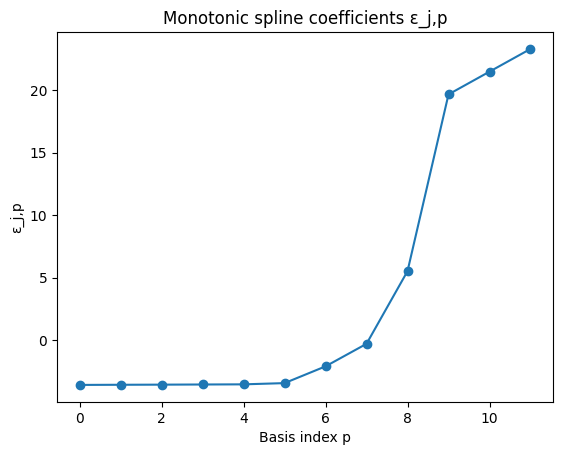

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(len(eps)), eps, marker='o')
plt.title("Monotonic spline coefficients ε_j,p")
plt.xlabel("Basis index p")
plt.ylabel("ε_j,p")
plt.show()

In [12]:
# Monotonic?
is_mono = torch.all(torch.diff(eps) > 0)
print(is_mono)

tensor(True)


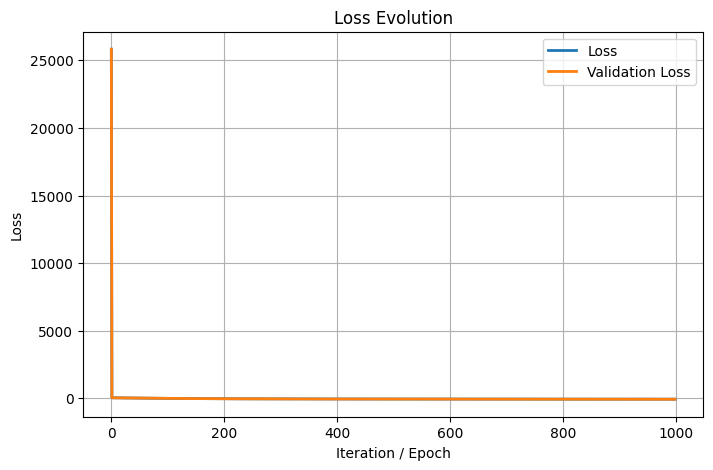

In [13]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

24 24
tensor([-3.6775, -4.3683, -4.3621, -4.4498, -4.4703, -2.5600,  1.4305,  0.6816,
         9.0407,  1.6411,  1.6411,  1.6411, -3.5771, -4.4075, -4.6283, -4.4024,
        -4.4232, -2.2685,  1.0383,  1.6226,  5.8111, 14.1400,  1.6411,  1.6411])


In [15]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [ ]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [ ]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [16]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [18]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  7.9913
KLD Gaussian Train Data:  0.1075
KLD Copula   Train Data:  -0.0007
KLD GTM      Test  Data:  7.9995
KLD Gaussian Test  Data:  0.1071
KLD Copula   Test  Data:  0.0011


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [25]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

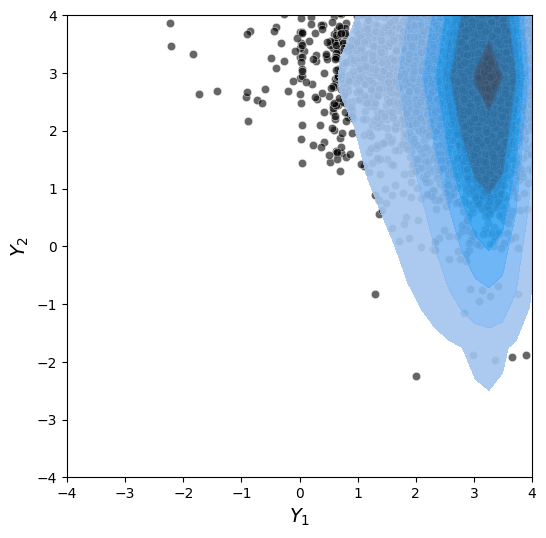

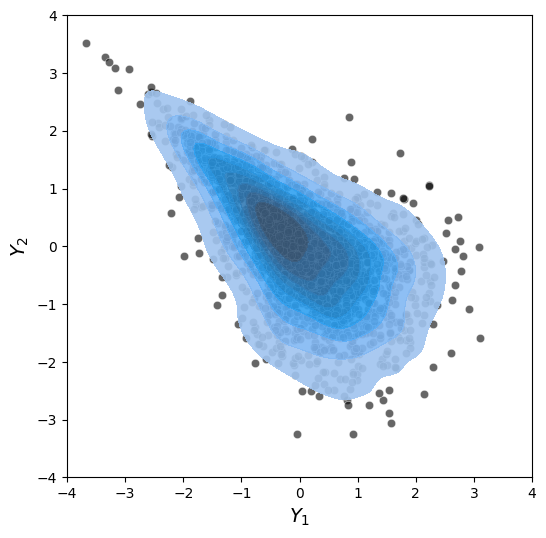

In [26]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [22]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

: 

: 

: 

: 

: 

: 

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


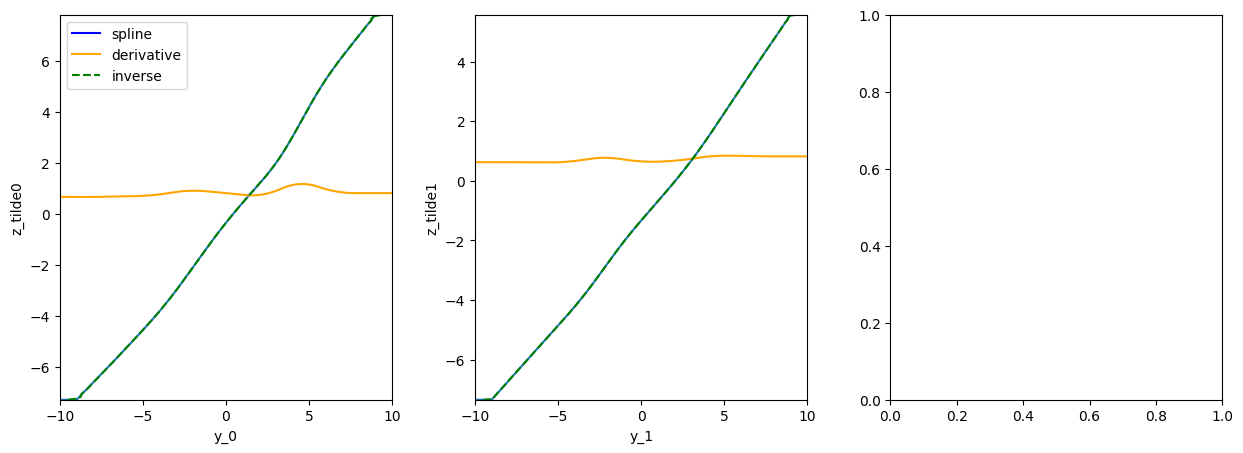

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


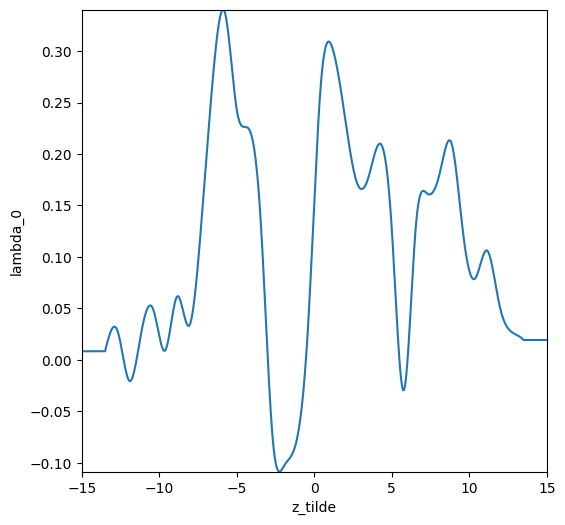

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


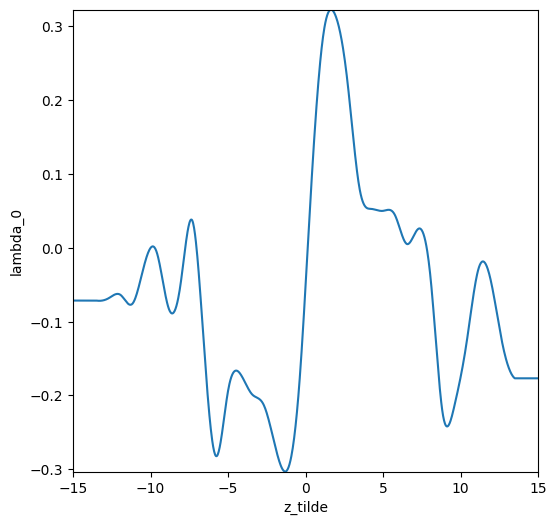

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


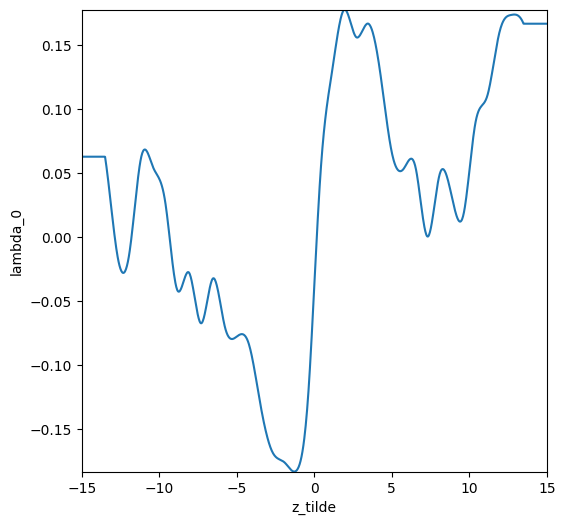

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)